In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"  
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, Dropout,  Input, Layer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.optimizers import Adam


from pandas_datareader import data

from PyEMD import EMD,EEMD,CEEMDAN,Visualisation

In [2]:
start = '2016-01-01'
end = '2021-01-01'
GSPC = pd.DataFrame(data.DataReader("^GSPC","yahoo",start,end)['Adj Close'])#Choose the data
print(GSPC)
GSPC.isnull().sum().sort_values(ascending = False)

              Adj Close
Date                   
2016-01-04  2012.660034
2016-01-05  2016.709961
2016-01-06  1990.260010
2016-01-07  1943.089966
2016-01-08  1922.030029
...                 ...
2020-12-24  3703.060059
2020-12-28  3735.360107
2020-12-29  3727.040039
2020-12-30  3732.040039
2020-12-31  3756.070068

[1259 rows x 1 columns]


Adj Close    0
dtype: int64

In [111]:
def emd_calculate(data,emdtype=EMD, plots=True):
    EMD_C=emdtype()#EMD,EEMD,CEEMDAN
    imfs = EMD_C(data.values.reshape(len(data)))
        
    if plots:
        series_index = data.index
        fig = plt.figure(figsize=(16,2*len(imfs)))
        plt.subplot(1+len(imfs), 1, 1 )
        plt.plot(series_index, data, color='#0070C0') #F27F19 orange #0070C0 blue
        plt.ylabel('Original data')

        # Plot IMFs
        for i in range(len(imfs)):
            plt.subplot(1 +len(imfs),1,2 + i)
            plt.plot(series_index, imfs[i, :], color='#F27F19')
            plt.ylabel('IMF'+str(i))
        plt.show()
    imfs=pd.DataFrame(imfs,columns=data.index)
    return imfs

In [78]:
def create_noisy(data,percentage=0.5,size=10):
    data_noisy = pd.DataFrame()
    window=int(len(data) * percentage)
    for i in range(window,len(data),size):
        data_noisy= pd.concat([data_noisy,pd.Series(data.values[i-window:i,0])], axis=1)
    return data_noisy.T

In [316]:
def create_pure(data,percentage=0.5,size=10,emdtype=EMD):
    data_pure = pd.DataFrame()
    window=int(len(data) * percentage)
    for i in range(window,len(data),size):
        temp=emd_calculate
        data_pure= pd.concat([data_pure,pd.Series(data.values[i-window:i,0])], axis=1)
    return data_pure.T

In [317]:
def reconstruction(data_emd):
    reconstruction = pd.DataFrame()
    for i in range(len(data_emd)):
        reconstruction['sum'+str(i)]=data_emd.iloc[i:,:].sum(axis=0)
    return reconstruction.T

In [318]:
GSPC_pure=create_pure(GSPC)

GSPC_noisy=create_noisy(GSPC)

In [151]:
mm_t_g = MinMaxScaler()
noise_mm = mm_t_g.fit_transform(GSPC_noisy.T).T
prue_mm=mm_t_g.fit_transform(GSPC_pure.T).T
print(prue_mm.shape)
print(noise_mm.shape)

(63, 629)
(63, 629)


In [160]:
X_train_mm = np.asarray(noise_mm)
X_train_mm=X_train_mm.reshape((len(X_train_mm), len(X_train_mm[0]), 1))
Y_train_mm = np.asarray(prue_mm)
Y_train_mm=Y_train_mm.reshape((len(Y_train_mm), len(Y_train_mm[0]), 1))
X_train_mm, X_val_mm, Y_train_mm, Y_val_mm = train_test_split(X_train_mm, Y_train_mm, test_size=0.2,random_state=0,shuffle=False)

In [158]:
keras.backend.clear_session()

In [161]:
def set_model_encoding_mm():
    model = Sequential()
    model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same',input_shape=(None, 1)))
    model.add(Conv1D(64, kernel_size=3,activation='relu',padding='same'))
    model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
    model.add(Conv1D(128, kernel_size=3,activation='relu',padding='same'))
    model.add(Conv1D(1,kernel_size=1,activation='sigmoid', padding='same'))
    model.compile(optimizer='adam' , loss='mse', metrics=['mae'])
    
    return model
modelen_mm = set_model_encoding_mm()
modelen_mm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 128)         512       
                                                                 
 conv1d_6 (Conv1D)           (None, None, 64)          24640     
                                                                 
 conv1d_7 (Conv1D)           (None, None, 64)          12352     
                                                                 
 conv1d_8 (Conv1D)           (None, None, 128)         24704     
                                                                 
 conv1d_9 (Conv1D)           (None, None, 1)           129       
                                                                 
Total params: 62,337
Trainable params: 62,337
Non-trainable params: 0
_________________________________________________________________


In [162]:
callback = EarlyStopping(monitor='loss', patience=10)
history_mm = modelen_mm.fit(X_train_mm, Y_train_mm, validation_data = (X_val_mm, Y_val_mm), epochs=400, batch_size=32, verbose=1, callbacks=[callback])

Epoch 1/400
2/2 [==============================] - 1s 171ms/step - loss: 0.0643 - mae: 0.2136 - val_loss: 0.0340 - val_mae: 0.1466
Epoch 2/400
2/2 [==============================] - 0s 55ms/step - loss: 0.0604 - mae: 0.2071 - val_loss: 0.0319 - val_mae: 0.1441
Epoch 3/400
2/2 [==============================] - 0s 52ms/step - loss: 0.0566 - mae: 0.2005 - val_loss: 0.0298 - val_mae: 0.1422
Epoch 4/400
2/2 [==============================] - 0s 52ms/step - loss: 0.0520 - mae: 0.1916 - val_loss: 0.0289 - val_mae: 0.1434
Epoch 5/400
2/2 [==============================] - 0s 55ms/step - loss: 0.0479 - mae: 0.1828 - val_loss: 0.0284 - val_mae: 0.1439
Epoch 6/400
2/2 [==============================] - 0s 52ms/step - loss: 0.0448 - mae: 0.1755 - val_loss: 0.0261 - val_mae: 0.1379
Epoch 7/400
2/2 [==============================] - 0s 51ms/step - loss: 0.0409 - mae: 0.1673 - val_loss: 0.0216 - val_mae: 0.1237
Epoch 8/400
2/2 [==============================] - 0s 47ms/step - loss: 0.0360 - mae: 0.1

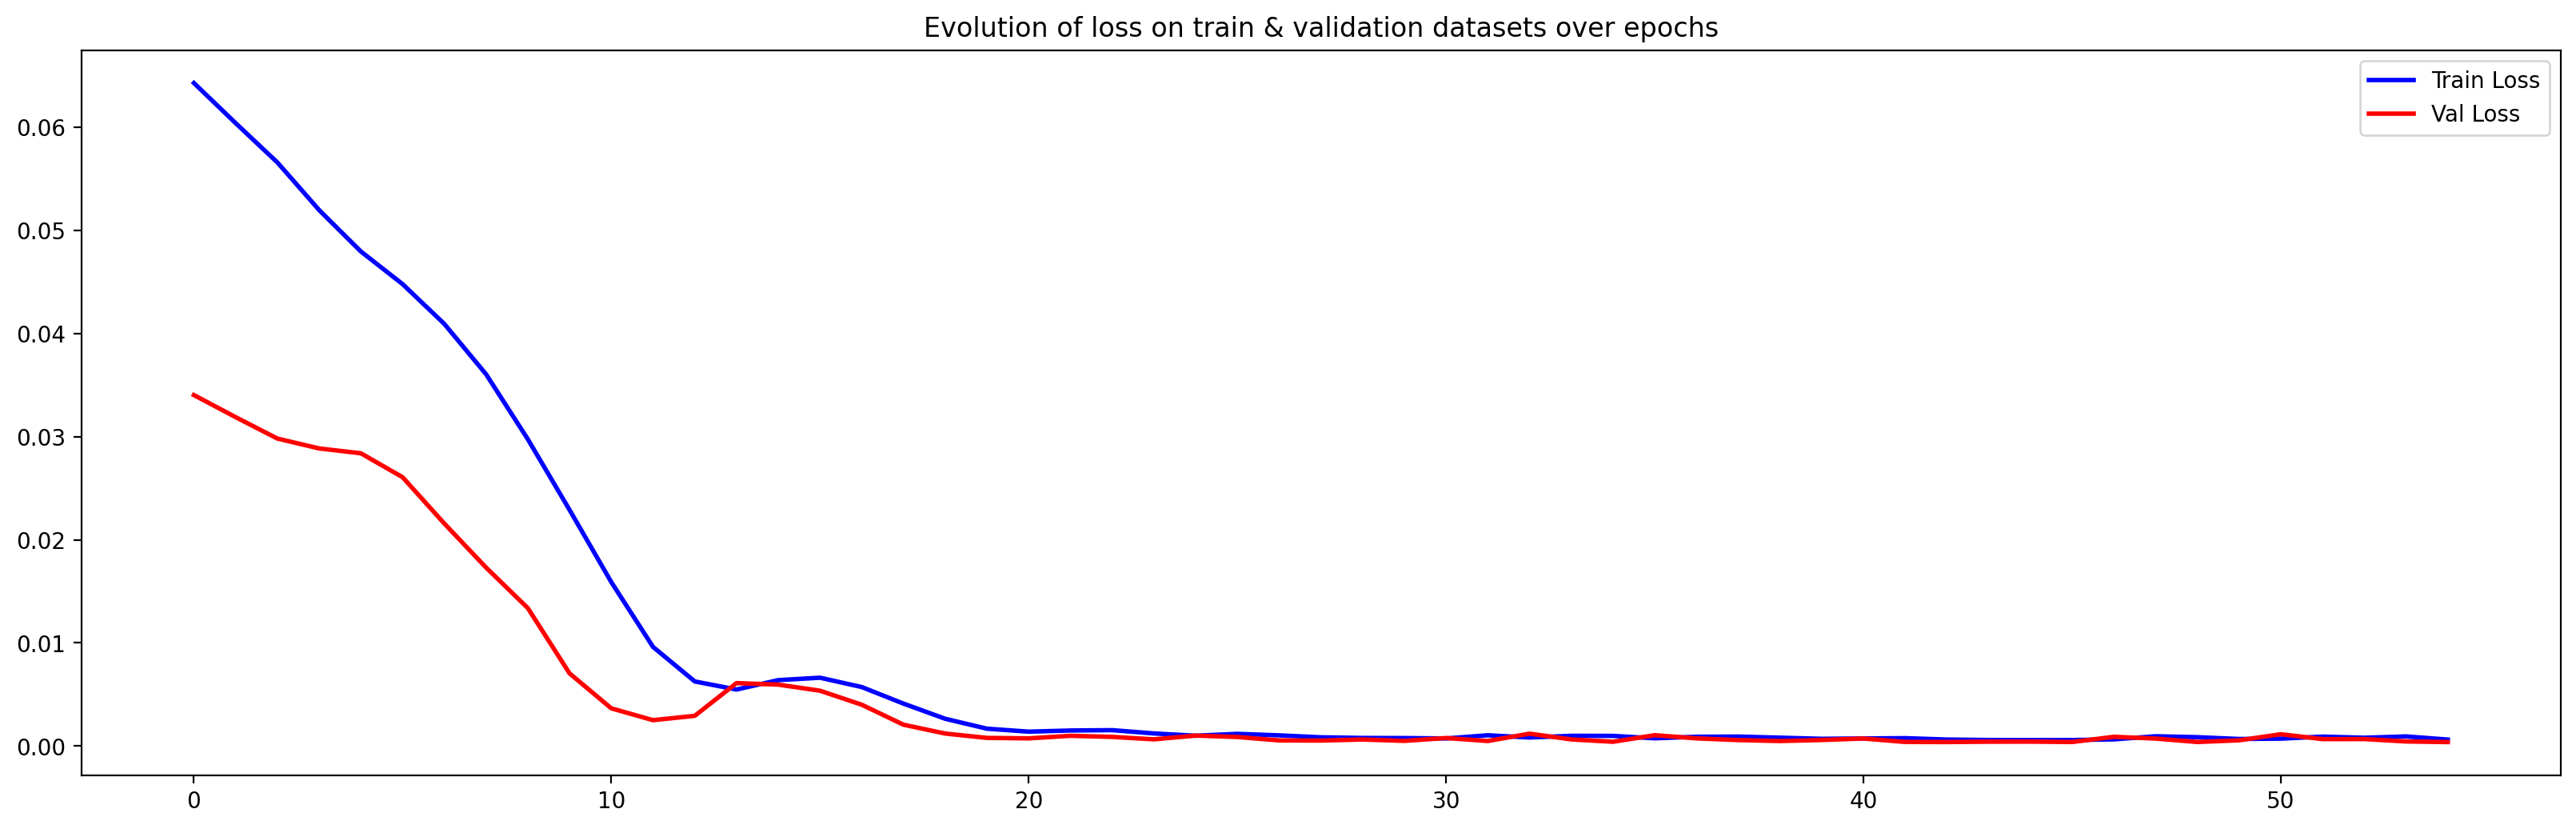

In [163]:
# Check how loss & mae went down
epoch_loss = history_mm.history['loss']
epoch_val_loss = history_mm.history['val_loss']

plt.figure(figsize=(20,6),dpi=200)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')


plt.show()

In [286]:
start = '2016-01-01'
end = '2022-01-01'
GSPC_test = pd.DataFrame(data.DataReader("^GSPC","yahoo",start,end)['Adj Close'])#Choose the data
GSPC_test

,Adj Close
Date,
2016-01-04,2012.660034
2016-01-05,2016.709961
2016-01-06,1990.260010
2016-01-07,1943.089966
2016-01-08,1922.030029
...,...
2021-12-27,4791.189941
2021-12-28,4786.350098
2021-12-29,4793.060059


1/1 [==============================] - 0s 18ms/step


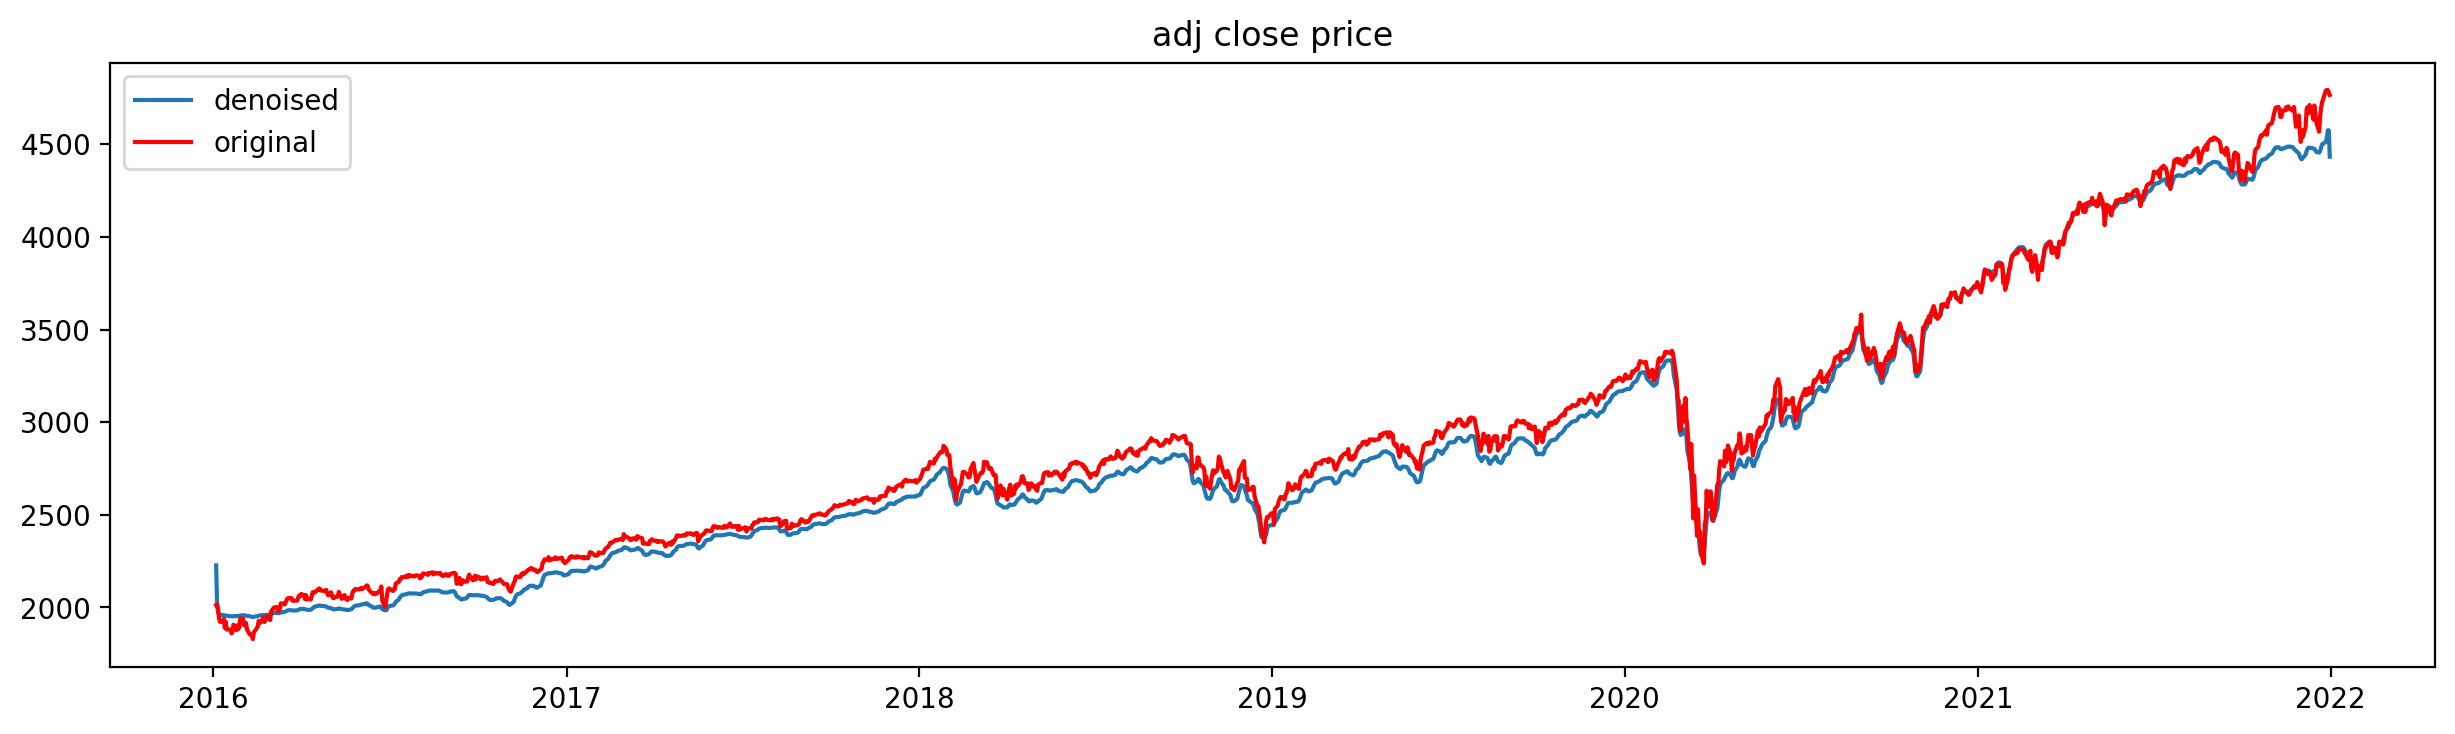

In [287]:
mm_t = MinMaxScaler()
noise_mm_T=mm_t.fit_transform(GSPC_test)
Y_test_mm_cnn = modelen_mm.predict(noise_mm_T.T)
Y_test_mm_cnn=Y_test_mm_cnn.reshape((len(GSPC_test),1))
pure_mm_cnn = mm_t.inverse_transform(Y_test_mm_cnn)
pure_mm_cnn=pd.DataFrame(pure_mm_cnn,columns=['Adj Close'],index=GSPC_test.index)
plt.figure(figsize=(15,4),dpi=200)
plt.plot(pure_mm_cnn)
plt.plot(GSPC_test,'r')
plt.title('adj close price')
plt.legend(['denoised', 'original'], loc='upper left')

# EMDCNN

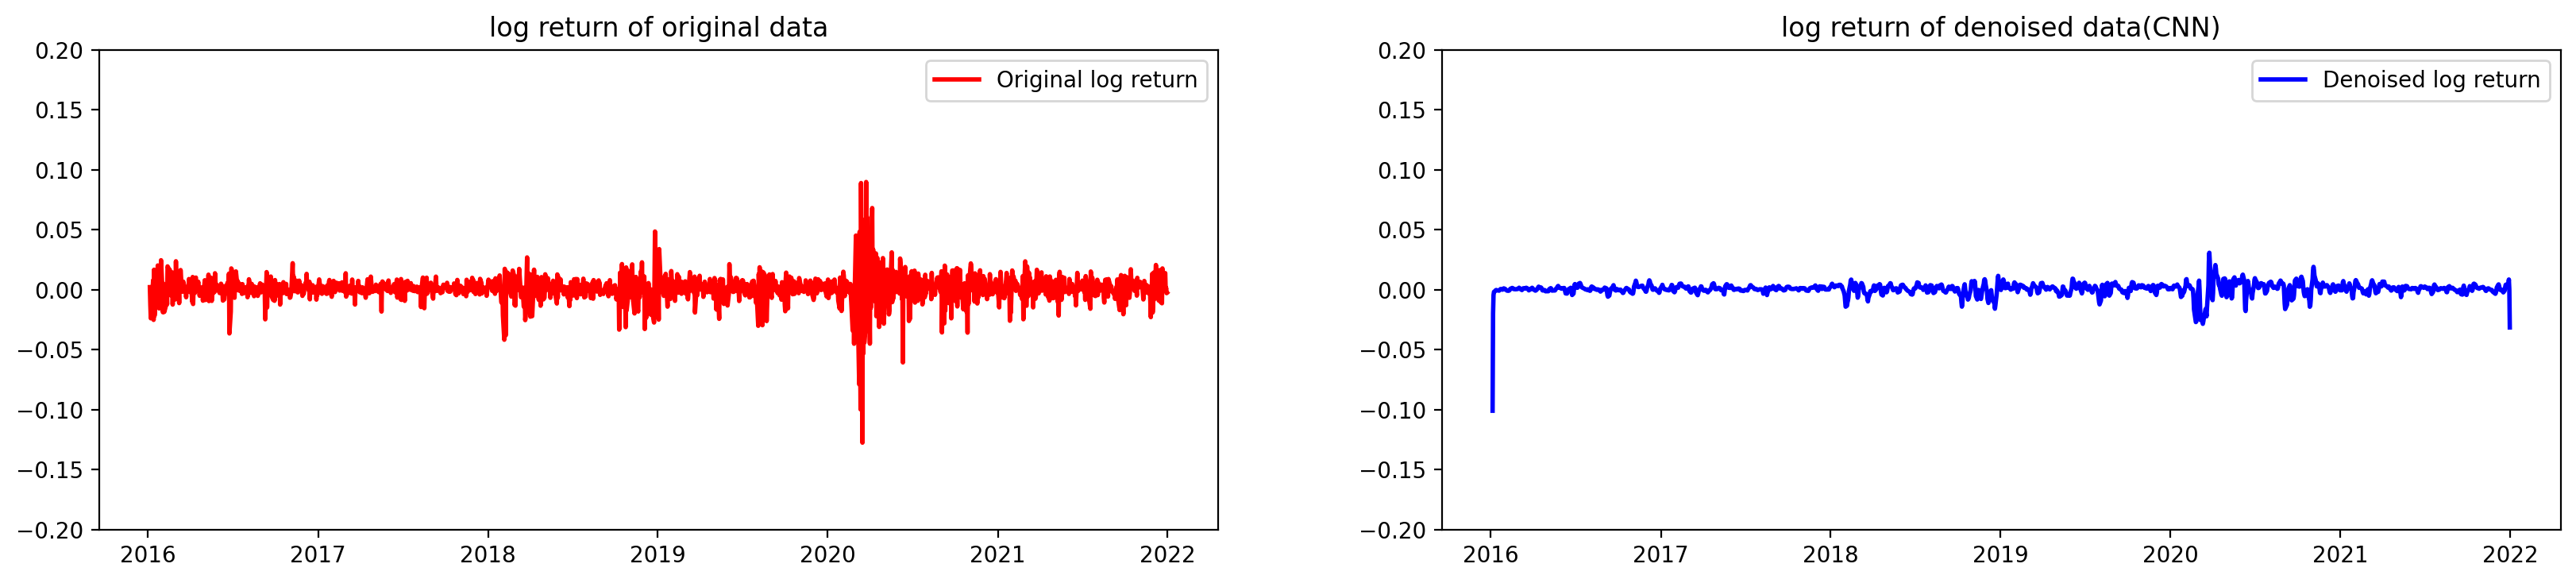

In [288]:
# Log Returns
GSPC_test_n=GSPC_test.copy()
GSPC_test_n['log_ret'] = np.log(GSPC_test.iloc[:,0]).diff()
pure_mm_cnn['log_ret'] = np.log(pure_mm_cnn.iloc[:,0]).diff()


plt.figure(figsize=(20,4),dpi=200)
plt.subplot(1,2,1)
plt.plot(GSPC_test_n['log_ret'], 'r-', linewidth=2, label='Original log return')
plt.ylim(-0.2,0.2)
plt.title('log return of original data')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(pure_mm_cnn['log_ret'] , 'b-', linewidth=2, label='Denoised log return')
plt.ylim(-0.2,0.2)
plt.title('log return of denoised data(CNN)')
plt.legend(loc='best')


plt.show()

In [289]:
def svmf1(dataset,dataset2,long_predict=10,percentage=1):
    f11=np.empty(0)
    f12=np.empty(0)
    max_t=0
    if dataset['log_ret'].max()>dataset2['log_ret'].max():
        max_t=dataset2['log_ret'].max()
    else:
        max_t=dataset['log_ret'].max()
    for n in np.arange(0.0, (percentage*max_t), (percentage*max_t)/50):#get multiple threshold
        threshold = n
        # for dataset
        daily_label=np.empty(0)#make the data labelled
        for i in range(0,len(dataset)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label=np.append(daily_label,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label=np.append(daily_label,n)
            else:
                n=1
                daily_label=np.append(daily_label,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f11=np.append(f11,f1)
        
        # for dataset2
    for n in np.arange(0.0, (0.5*max_t), (0.5*max_t)/50):#get multiple threshold
        threshold = n
        daily_label2=np.empty(0)#make the data labelled
        for i in range(0,len(dataset2)):
            if dataset2.iloc[i,1]<-threshold:
                n=-1
                daily_label2=np.append(daily_label2,n)
            elif abs(dataset2.iloc[i,1])<=threshold:
                n=0
                daily_label2=np.append(daily_label2,n)
            else:
                n=1
                daily_label2=np.append(daily_label2,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset2)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset2.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label2[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f12=np.append(f12,f1)
    return f11,f12

In [230]:
original_svm,denoised_svm=svmf1(GSPC_test_n,pure_mm_cnn,long_predict=1)

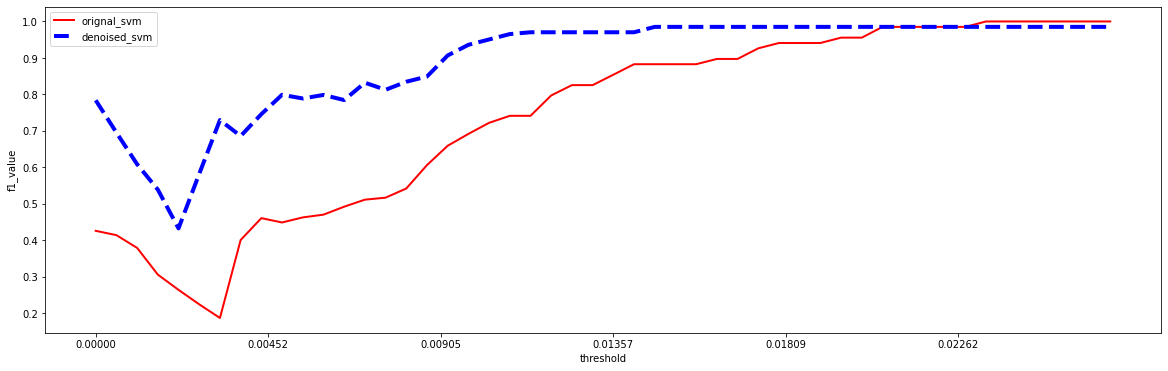

In [231]:
plt.figure(figsize=(20,6))
percentage=1
max_t=0
if GSPC_test_n['log_ret'].max()>pure_mm_cnn['log_ret'].max():
    max_t=pure_mm_cnn['log_ret'].max()
else:
    max_t=GSPC_test_n['log_ret'].max()
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/50),original_svm,label='orignal_svm', color='red', linewidth=2.0)
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/50),denoised_svm,label='denoised_svm', color='blue', linewidth=4.0, linestyle='--')

plt.xticks(np.arange(0.0,(percentage*max_t), (percentage*max_t)/6))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()

In [233]:
def svmf1_ori(dataset,dataset2,long_predict=10,percentage=1):
    f11=np.empty(0)
    f12=np.empty(0)
    max_t=0
    if dataset['log_ret'].max()>dataset2['log_ret'].max():
        max_t=dataset2['log_ret'].max()
    else:
        max_t=dataset['log_ret'].max()
    for n in np.arange(0.0, (percentage*max_t), (percentage*max_t)/50):#get multiple threshold
        threshold = n
        # for dataset
        daily_label=np.empty(0)#make the data labelled
        for i in range(0,len(dataset)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label=np.append(daily_label,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label=np.append(daily_label,n)
            else:
                n=1
                daily_label=np.append(daily_label,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f11=np.append(f11,f1)
        
        # for dataset2
    for n in np.arange(0.0, (0.5*max_t), (0.5*max_t)/50):#get multiple threshold
        threshold = n
        daily_label2=np.empty(0)#make the data labelled
        for i in range(0,len(dataset2)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label2=np.append(daily_label2,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label2=np.append(daily_label2,n)
            else:
                n=1
                daily_label2=np.append(daily_label2,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset2)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset2.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label2[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f12=np.append(f12,f1)
    return f11,f12

In [237]:
original_svm_ori,denoised_svm_ori=svmf1_ori(GSPC_test_n,pure_mm_cnn,long_predict=1)

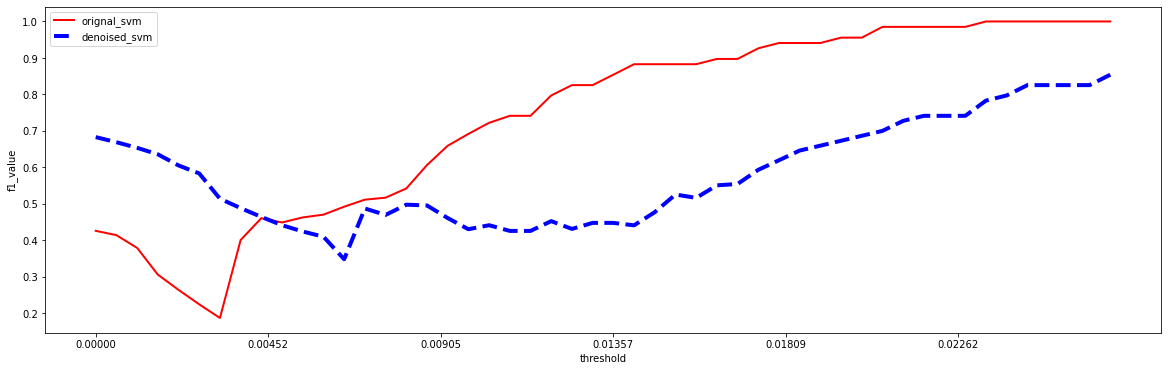

In [238]:
plt.figure(figsize=(20,6))
percentage=1
max_t=0
if GSPC_test_n['log_ret'].max()>pure_mm_cnn['log_ret'].max():
    max_t=pure_mm_cnn['log_ret'].max()
else:
    max_t=GSPC_test_n['log_ret'].max()
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/50),original_svm_ori,label='orignal_svm', color='red', linewidth=2.0)
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/50),denoised_svm_ori,label='denoised_svm', color='blue', linewidth=4.0, linestyle='--')

plt.xticks(np.arange(0.0,(percentage*max_t), (percentage*max_t)/6))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()

## Strategies 

## Bollinger band

In [290]:
def bbands(close_prices, window, no_of_stdev):#bollinger  bands, using today's closing price

    rolling_mean = close_prices.rolling(window,min_periods=1).mean()#.shift(1)
    rolling_std = close_prices.rolling(window,min_periods=1).std()#.shift(1)
    

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band

In [291]:
def buy_signal_function(dataset):
    buy_signal=pd.DataFrame(columns=['Price'],index=dataset.index)
    buy_signal['Price']=dataset['Adj Close']
    buy_signal['mean'],buy_signal['upper'],buy_signal['lower']=bbands(dataset['Adj Close'],20,2)
    buy_signal['side'] = np.nan 
    buy_signal['signal'] = np.nan 
    for i in range(0,len(dataset)):
        if (buy_signal.iloc[i,0]<buy_signal.iloc[i,3]):
            buy_signal.iloc[i,4]=1
            if (buy_signal.iloc[i-1,0]>=buy_signal.iloc[i-1,3]):
                buy_signal.iloc[i,5]=1
        elif (buy_signal.iloc[i,0]>buy_signal.iloc[i,2]):
            buy_signal.iloc[i,4]=-1
            if (buy_signal.iloc[i-1,0]<=buy_signal.iloc[i-1,2]):
                buy_signal.iloc[i,5]=-1
    return buy_signal

In [292]:
GSPC_test_signal=buy_signal_function(GSPC_test_n)


pure_mm_cnn_signal=buy_signal_function(pure_mm_cnn)


In [293]:

print('GSPC_test_signal:\n',GSPC_test_signal.signal.value_counts(),'\n')
print('pure_mm_cnn_signal:\n',pure_mm_cnn_signal.signal.value_counts(),'\n')


GSPC_test_signal:
 -1.0    47
 1.0    34
Name: signal, dtype: int64 

pure_mm_cnn_signal:
 -1.0    38
 1.0    22
Name: signal, dtype: int64 



In [294]:
print(GSPC_test[GSPC_test_signal.signal == 1.0])
print(GSPC_test[pure_mm_cnn_signal.signal == 1.0])

              Adj Close
Date                   
2016-06-24  2037.410034
2016-09-09  2127.810059
2016-09-13  2127.020020
2016-11-01  2111.719971
2017-03-21  2344.020020
2017-04-13  2328.949951
2017-06-29  2419.699951
2017-07-06  2409.750000
2017-08-10  2438.209961
2017-08-17  2430.010010
2018-02-05  2648.939941
2018-02-08  2581.000000
2018-03-22  2643.689941
2018-06-27  2699.629883
2018-10-10  2785.679932
2018-10-24  2656.100098
2018-12-17  2545.939941
2018-12-19  2506.959961
2019-05-13  2811.870117
2019-05-31  2752.060059
2019-08-01  2953.560059
2019-10-01  2940.250000
2020-02-25  3128.209961
2020-03-09  2746.560059
2020-03-12  2480.639893
2020-03-16  2386.129883
2020-10-28  3271.030029
2020-10-30  3269.959961
2021-03-04  3768.469971
2021-05-12  4063.040039
2021-09-20  4357.729980
2021-09-30  4307.540039
2021-11-26  4594.620117
2021-11-30  4567.000000
              Adj Close
Date                   
2016-02-10  1851.859985
2016-06-27  2000.540039
2016-09-08  2181.300049
2016-10-13  2132

In [295]:
print(GSPC_test[GSPC_test_signal.signal == -1.0])
print(GSPC_test[pure_mm_cnn_signal.signal == -1.0])

              Adj Close
Date                   
2016-04-13  2082.419922
2016-04-18  2094.340088
2016-05-25  2090.540039
2016-05-27  2099.060059
2016-12-07  2241.350098
2016-12-13  2271.719971
2017-01-25  2298.370117
2017-02-10  2316.100098
2017-02-21  2365.379883
2017-04-25  2388.610107
2017-06-02  2439.070068
2017-07-14  2459.270020
2017-07-19  2473.830078
2017-09-12  2496.479980
2017-10-05  2552.070068
2017-10-27  2581.070068
2017-11-28  2627.040039
2018-01-04  2723.989990
2018-01-12  2786.239990
2018-05-10  2723.070068
2018-06-06  2772.350098
2018-08-27  2896.739990
2018-09-20  2930.750000
2019-03-18  2832.939941
2019-03-21  2854.879883
2019-07-03  2995.820068
2019-09-05  2976.000000
2019-12-12  3168.570068
2019-12-16  3191.449951
2019-12-20  3221.219971
2020-01-16  3316.810059
2020-05-27  3036.129883
2020-06-05  3193.929932
2020-08-06  3349.159912
2020-08-26  3478.729980
2020-08-28  3508.010010
2020-09-02  3580.840088
2020-10-12  3534.219971
2020-12-31  3756.070068
2021-01-07  3803

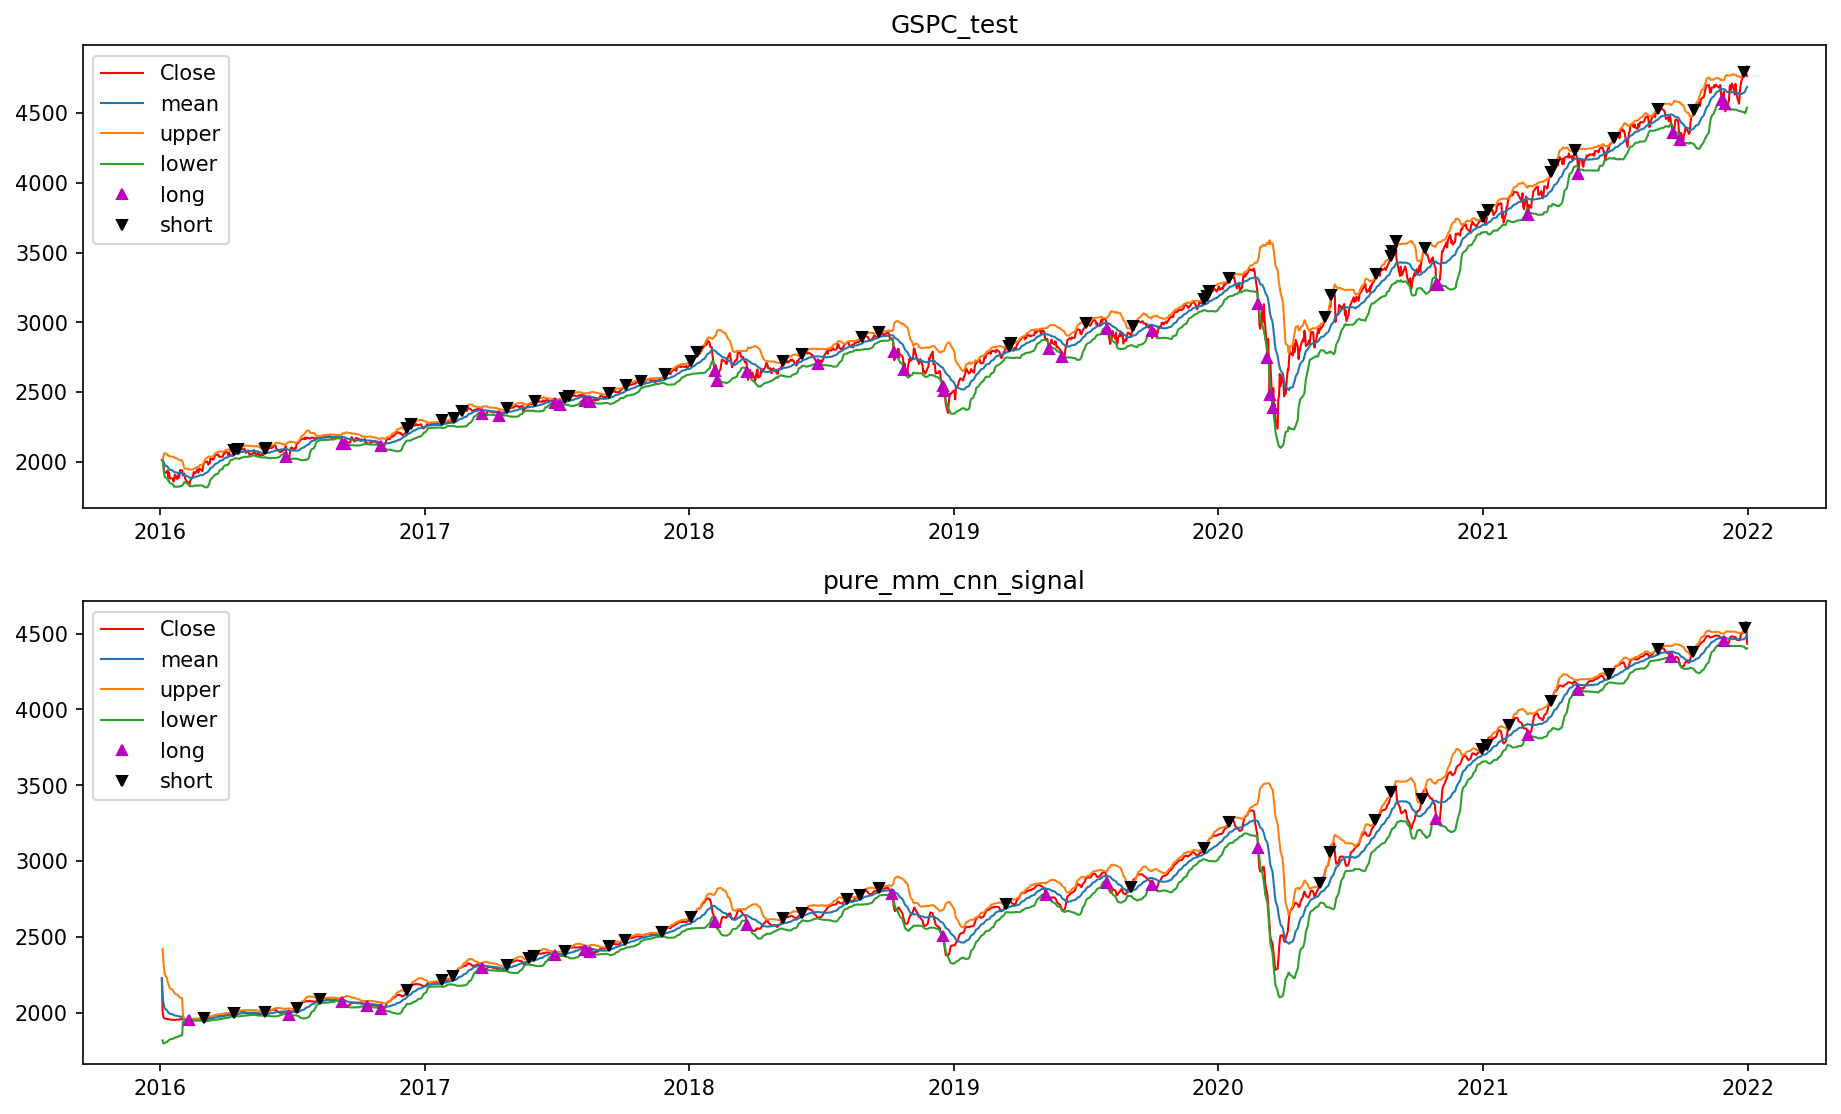

In [296]:
plt.figure(figsize=(15,9),dpi=150)
plt.subplot(2,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test_signal['Price'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_signal[['mean','upper','lower']], lw=1,label=['mean','upper','lower'])
plt.plot(GSPC_test_signal.loc[GSPC_test_signal.signal == 1.0].index, 
         GSPC_test_signal.Price[GSPC_test_signal.signal == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_signal.loc[GSPC_test_signal.signal == -1.0].index, 
         GSPC_test_signal.Price[GSPC_test_signal.signal == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(2,1,2)
plt.title('pure_mm_cnn_signal')
plt.plot(pure_mm_cnn_signal['Price'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_signal[['mean','upper','lower']], lw=1,label=['mean','upper','lower'])
plt.plot(pure_mm_cnn_signal.loc[pure_mm_cnn_signal.signal == 1.0].index, 
         pure_mm_cnn_signal.Price[pure_mm_cnn_signal.signal == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnn_signal.loc[pure_mm_cnn_signal.signal == -1.0].index, 
         pure_mm_cnn_signal.Price[pure_mm_cnn_signal.signal == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()    


## MACD

In [297]:
def MACD(dataset,short_window = 12,long_window = 26, signal_window=9):
    # Initiate short and long windows

    # Initialise the `signals` dataframe and add the `signal` column
    signals = pd.DataFrame(index=dataset.index)
    signals['signal'] = 0.0

    # Calculate short term moving averages
    signals['short_mavg'] = dataset['Adj Close'].ewm(span=short_window, min_periods=1).mean()

    # Calculate long term moving averages
    signals['long_mavg'] = dataset['Adj Close'].ewm(span=long_window, min_periods=1).mean()
    
    # Calculate DIF 
    signals['DIF'] = signals['short_mavg']-signals['long_mavg']
    
     # Calculate DIF moving averages
    signals['DEA'] = signals['DIF'].ewm(span=signal_window, min_periods=1).mean()

    # Generate signal
    signals['signal'] = np.where(signals['DIF']> signals['DEA'], 1.0, 0.0)   

    # Generate trading orders
    signals['positions'] = signals['signal'].diff()
    return signals

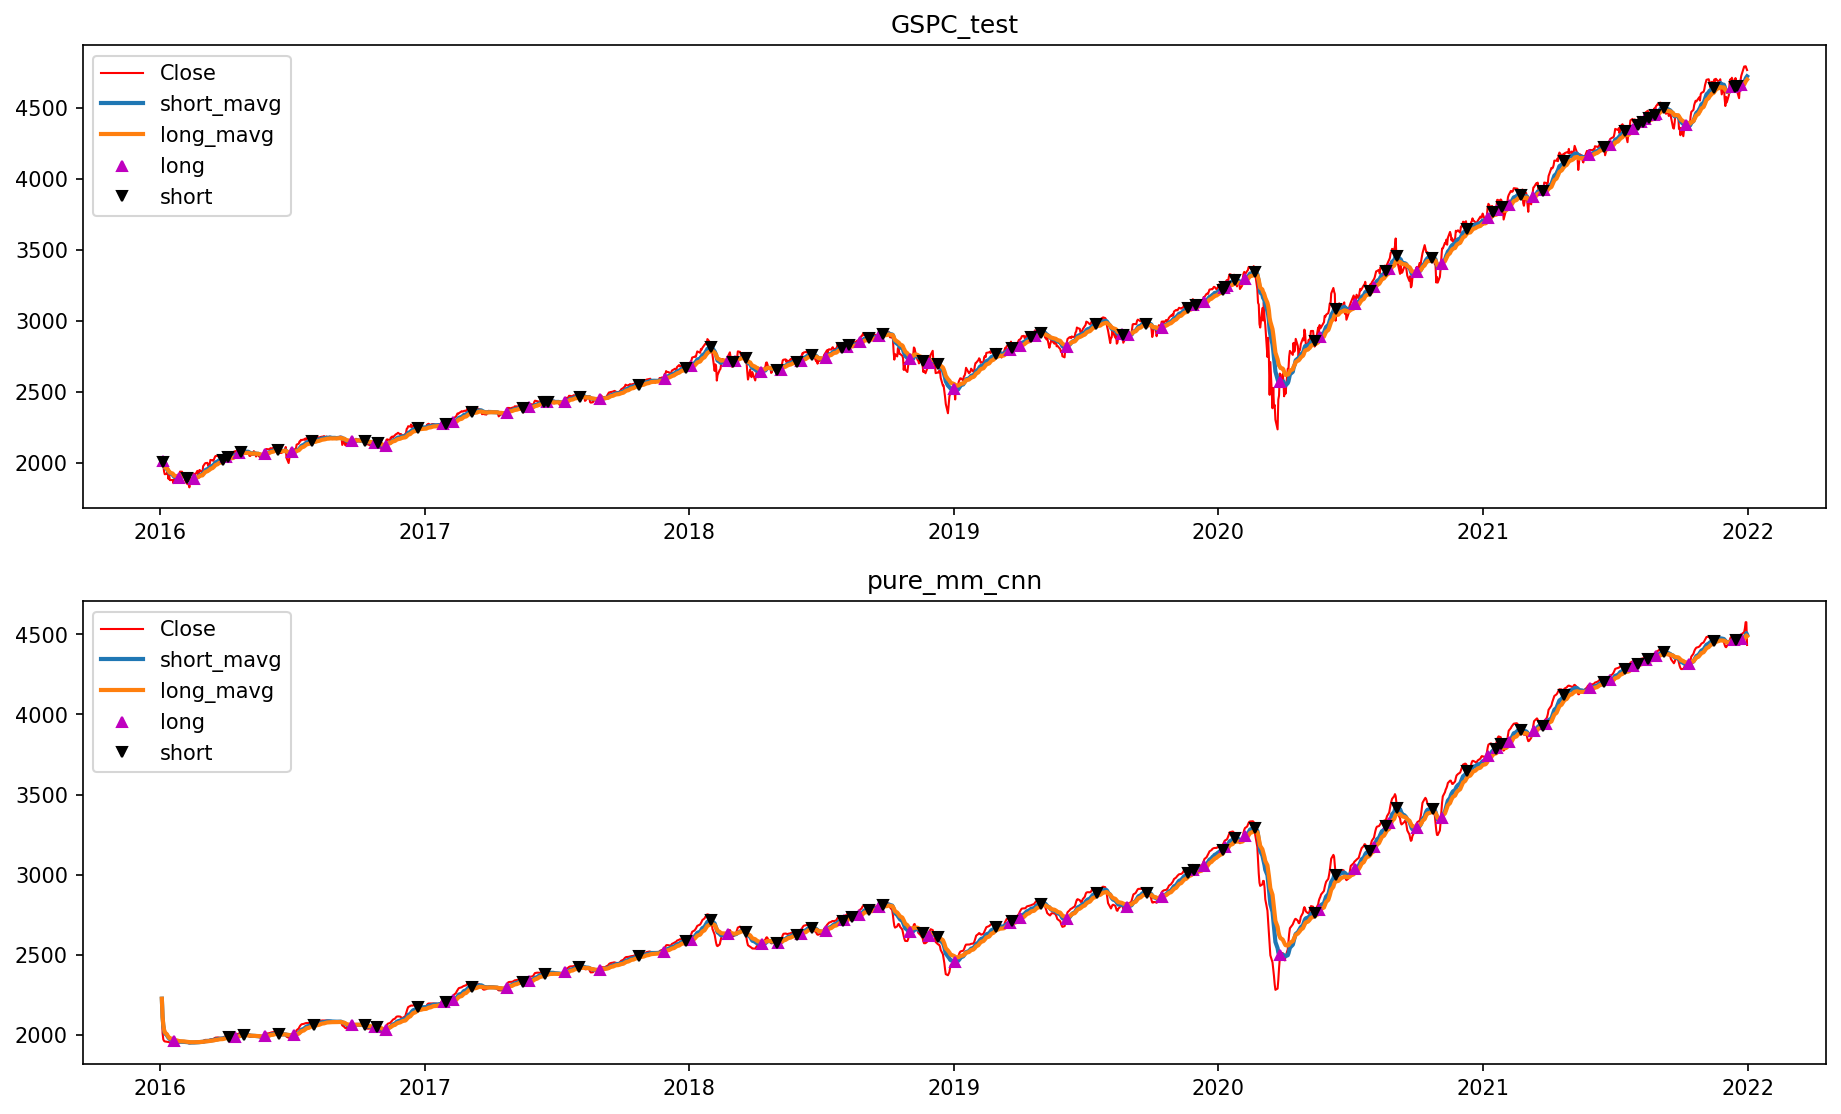

In [298]:
GSPC_test_macd=MACD(GSPC_test_n,short_window = 14,long_window = 22)
pure_mm_cnn_macd=MACD(pure_mm_cnn,short_window = 14,long_window = 22)
#pure_mm_lstm_macd=MACD(pure_mm_lstm,short_window = 14,long_window = 22)

plt.figure(figsize=(15,9),dpi=150)
plt.subplot(2,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test_n['Adj Close'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_macd[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(GSPC_test_macd.loc[GSPC_test_macd.positions == 1.0].index, 
         GSPC_test_macd.short_mavg[GSPC_test_macd.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_macd.loc[GSPC_test_macd.positions == -1.0].index, 
         GSPC_test_macd.short_mavg[GSPC_test_macd.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(2,1,2)
plt.title('pure_mm_cnn')
plt.plot(pure_mm_cnn['Adj Close'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_macd[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(pure_mm_cnn_macd.loc[pure_mm_cnn_macd.positions == 1.0].index, 
         pure_mm_cnn_macd.short_mavg[pure_mm_cnn_macd.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnn_macd.loc[pure_mm_cnn_macd.positions == -1.0].index, 
         pure_mm_cnn_macd.short_mavg[pure_mm_cnn_macd.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()   



In [299]:
print('GSPC_test_macd:\n',GSPC_test_macd.positions.value_counts(),'\n')
print('pure_mm_cnn_macd:\n',pure_mm_cnn_macd.positions.value_counts(),'\n')

GSPC_test_macd:
  0.0    1379
 1.0      66
-1.0      65
Name: positions, dtype: int64 

pure_mm_cnn_macd:
  0.0    1401
 1.0      55
-1.0      54
Name: positions, dtype: int64 



In [300]:
print(GSPC_test[GSPC_test_macd['positions']==1])
print(GSPC_test[pure_mm_cnn_macd['positions']==1])

              Adj Close
Date                   
2016-01-05  2016.709961
2016-01-27  1882.949951
2016-02-17  1926.819946
2016-04-01  2072.780029
2016-04-19  2100.800049
...                 ...
2021-08-27  4509.370117
2021-10-08  4391.339844
2021-12-10  4712.020020
2021-12-15  4709.850098
2021-12-23  4725.790039

[66 rows x 1 columns]
              Adj Close
Date                   
2016-01-21  1868.989990
2016-04-14  2082.780029
2016-05-25  2090.540039
2016-07-05  2088.550049
2016-09-23  2164.689941
2016-10-24  2151.330078
2016-11-08  2139.560059
2017-01-27  2294.689941
2017-02-09  2307.870117
2017-04-24  2374.149902
2017-05-25  2415.070068
2017-07-14  2459.270020
2017-08-31  2471.649902
2017-11-27  2601.419922
2018-01-03  2713.060059
2018-02-23  2747.300049
2018-04-11  2642.189941
2018-05-04  2663.419922
2018-06-04  2746.870117
2018-07-09  2784.169922
2018-08-03  2840.350098
2018-08-23  2856.979980
2018-09-20  2930.750000
2018-11-02  2723.060059
2018-11-28  2743.790039
2019-01-03  2447.

In [301]:
print(GSPC_test[GSPC_test_macd['positions']==-1])
print(GSPC_test[pure_mm_cnn_macd['positions']==-1])

              Adj Close
Date                   
2016-01-06  1990.260010
2016-02-08  1853.439941
2016-03-28  2037.050049
2016-04-04  2066.129883
2016-04-22  2091.580078
...                 ...
2021-08-26  4470.000000
2021-09-08  4514.069824
2021-11-15  4682.799805
2021-12-14  4634.089844
2021-12-17  4620.640137

[65 rows x 1 columns]
              Adj Close
Date                   
2016-04-06  2066.659912
2016-04-27  2095.149902
2016-06-14  2075.320068
2016-08-01  2170.840088
2016-10-11  2136.729980
2016-10-27  2133.040039
2016-12-23  2263.790039
2017-01-30  2280.899902
2017-03-07  2368.389893
2017-05-16  2400.669922
2017-06-16  2433.149902
2017-08-02  2477.570068
2017-10-23  2564.979980
2017-12-27  2682.620117
2018-01-31  2823.810059
2018-03-20  2716.939941
2018-05-02  2635.669922
2018-05-30  2724.010010
2018-06-19  2762.590088
2018-08-01  2813.360107
2018-08-13  2821.929932
2018-09-06  2878.050049
2018-09-26  2905.969971
2018-11-20  2641.889893
2018-12-10  2637.719971
2019-02-28  2784.

## MA

In [302]:
def MA(dataset,short_window = 10,long_window = 50):
    # Initiate short and long windows

    # Initialise the `signals` dataframe and add the `signal` column
    signals = pd.DataFrame(index=dataset.index)
    signals['signal'] = 0.0

    # Calculate short term simple moving averages
    signals['short_mavg'] = dataset['Adj Close'].rolling(window=short_window, min_periods=1).mean()

    # Calculate long term simple moving averages
    signals['long_mavg'] = dataset['Adj Close'].rolling(window=long_window, min_periods=1).mean()

    # Generate signal
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                                > signals['long_mavg'][short_window:], 1.0, 0.0)   

    # Generate trading orders
    signals['positions'] = signals['signal'].diff()
    return signals

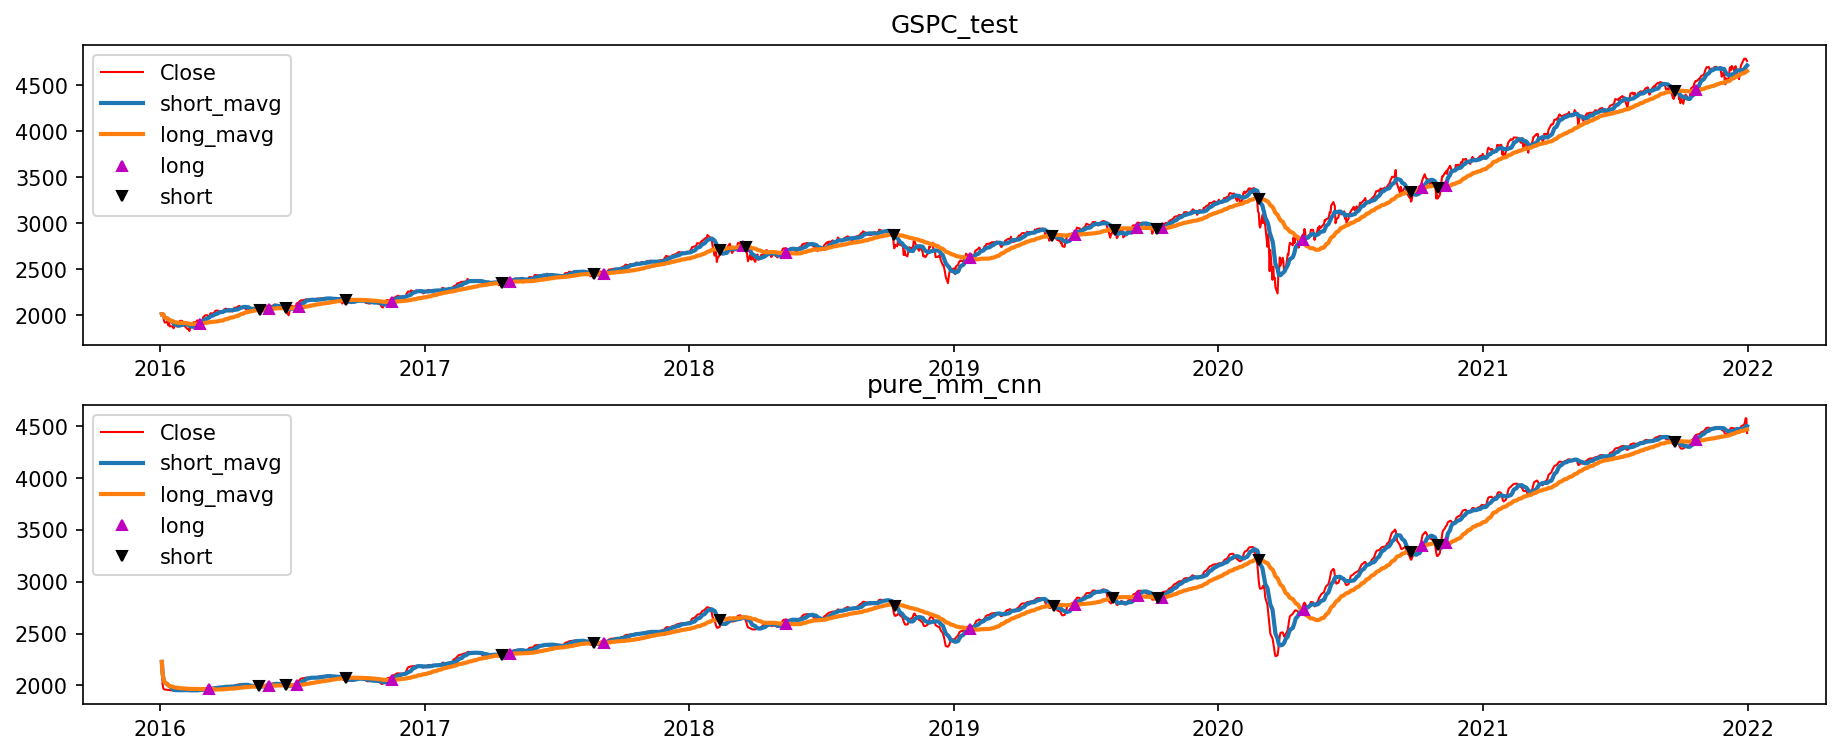

In [303]:
GSPC_test_ma=MA(GSPC_test,short_window = 10,long_window = 50)
pure_mm_cnn_ma=MA(pure_mm_cnn,short_window = 10,long_window = 50)
#pure_mm_lstm_ma=MA(pure_mm_lstm,short_window = 10,long_window = 50)

plt.figure(figsize=(15,9),dpi=150)
plt.subplot(3,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test['Adj Close'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_ma[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(GSPC_test_ma.loc[GSPC_test_ma.positions == 1.0].index, 
         GSPC_test_ma.short_mavg[GSPC_test_ma.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_ma.loc[GSPC_test_ma.positions == -1.0].index, 
         GSPC_test_ma.short_mavg[GSPC_test_ma.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(3,1,2)
plt.title('pure_mm_cnn')
plt.plot(pure_mm_cnn['Adj Close'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_ma[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(pure_mm_cnn_ma.loc[pure_mm_cnn_ma.positions == 1.0].index, 
         pure_mm_cnn_ma.short_mavg[pure_mm_cnn_ma.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnn_ma.loc[pure_mm_cnn_ma.positions == -1.0].index, 
         pure_mm_cnn_ma.short_mavg[pure_mm_cnn_ma.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()   



In [304]:
print('GSPC_test_ma:\n',GSPC_test_ma.positions.value_counts(),'\n')
print('pure_mm_cnn_ma:\n',pure_mm_cnn_ma.positions.value_counts(),'\n')

GSPC_test_ma:
  0.0    1479
 1.0      16
-1.0      15
Name: positions, dtype: int64 

pure_mm_cnn_ma:
  0.0    1481
 1.0      15
-1.0      14
Name: positions, dtype: int64 



In [305]:
print(GSPC_test[GSPC_test_ma['positions']==1])
print(GSPC_test[pure_mm_cnn_ma['positions']==1])

              Adj Close
Date                   
2016-02-25  1951.699951
2016-05-31  2096.949951
2016-07-11  2137.159912
2016-11-16  2176.939941
2017-04-28  2384.199951
2017-09-05  2457.850098
2018-03-16  2752.010010
2018-05-14  2730.129883
2019-01-24  2642.330078
2019-06-18  2917.750000
2019-09-11  3000.929932
2019-10-16  2989.689941
2020-04-27  2878.479980
2020-10-09  3477.139893
2020-11-10  3545.530029
2021-10-21  4549.779785
              Adj Close
Date                   
2016-03-09  1989.260010
2016-05-31  2096.949951
2016-07-08  2129.899902
2016-11-16  2176.939941
2017-04-28  2384.199951
2017-09-05  2457.850098
2018-05-14  2730.129883
2019-01-24  2642.330078
2019-06-18  2917.750000
2019-09-12  3009.570068
2019-10-15  2995.679932
2020-04-28  2863.389893
2020-10-09  3477.139893
2020-11-10  3545.530029
2021-10-22  4544.899902


In [306]:
print(GSPC_test[GSPC_test_ma['positions']==-1])
print(GSPC_test[pure_mm_cnn_ma['positions']==-1])

              Adj Close
Date                   
2016-05-19  2040.040039
2016-06-24  2037.410034
2016-09-14  2125.770020
2017-04-17  2349.010010
2017-08-22  2452.510010
2018-02-12  2656.000000
2018-03-20  2716.939941
2018-10-11  2728.370117
2019-05-17  2859.530029
2019-08-12  2882.699951
2019-10-09  2919.399902
2020-02-27  2978.760010
2020-09-23  3236.919922
2020-10-30  3269.959961
2021-09-22  4395.640137
              Adj Close
Date                   
2016-05-17  2047.209961
2016-06-24  2037.410034
2016-09-14  2125.770020
2017-04-17  2349.010010
2017-08-22  2452.510010
2018-02-12  2656.000000
2018-10-12  2767.129883
2019-05-20  2840.229980
2019-08-09  2918.649902
2019-10-10  2938.129883
2020-02-27  2978.760010
2020-09-23  3236.919922
2020-10-30  3269.959961
2021-09-23  4448.979980


## Strategies backtest

In [307]:
def combinesig(dataset,dataset1,dataset2,dataset3):    
    dataset_backtesting=pd.DataFrame()
    dataset_backtesting['Adj Close']=dataset['Adj Close']
    dataset_backtesting['masig']=dataset1['positions']
    dataset_backtesting['macdsig']=dataset2['positions']
    dataset_backtesting['bbsig']=dataset3['signal']
    return dataset_backtesting

In [308]:
GSPC_backtesting=combinesig(GSPC_test,GSPC_test_ma,GSPC_test_macd,GSPC_test_signal)
pure_mm_cnn_backtesting=combinesig(GSPC_test,pure_mm_cnn_ma,pure_mm_cnn_macd,pure_mm_cnn_signal)


In [309]:
def backtest(dataset,asset=1e8, signal=''):
    share_number = 0
    cash = asset
    for i in range(len(dataset)):
        if dataset[signal][i]==1:
            share_number=share_number+cash//(100*dataset['Adj Close'][i])*100
            if cash//(100*dataset['Adj Close'][i])*100>0:
                cash=cash-cash//(100*dataset['Adj Close'][i])*100*dataset['Adj Close'][i]
        elif dataset[signal][i]==-1:
            cash=cash+share_number*dataset['Adj Close'][i]
            share_number=0
    asset_now=cash+share_number*dataset['Adj Close'][i]
    return_value=(asset_now-asset)/asset
    return return_value

In [310]:
mareturn=backtest(GSPC_backtesting,signal='masig')
mareturn_cnn=backtest(pure_mm_cnn_backtesting,signal='masig')
print(mareturn)
print(mareturn_cnn)


0.7008293969726562
0.7705334633789063


In [311]:
mareturn=backtest(GSPC_backtesting,signal='macdsig')
mareturn_cnn=backtest(pure_mm_cnn_backtesting,signal='macdsig')
#mareturn_lstm=backtest(pure_mm_lstm_backtesting,signal='macdsig')
print(mareturn)
print(mareturn_cnn)
#print(mareturn_lstm)

0.6365485061035157
1.4703508190917969


In [312]:
mareturn=backtest(GSPC_backtesting,signal='bbsig')
mareturn_cnn=backtest(pure_mm_cnn_backtesting,signal='bbsig')
print(mareturn)
print(mareturn_cnn)


1.0990810927734376
0.6919556026611328


# Only emd

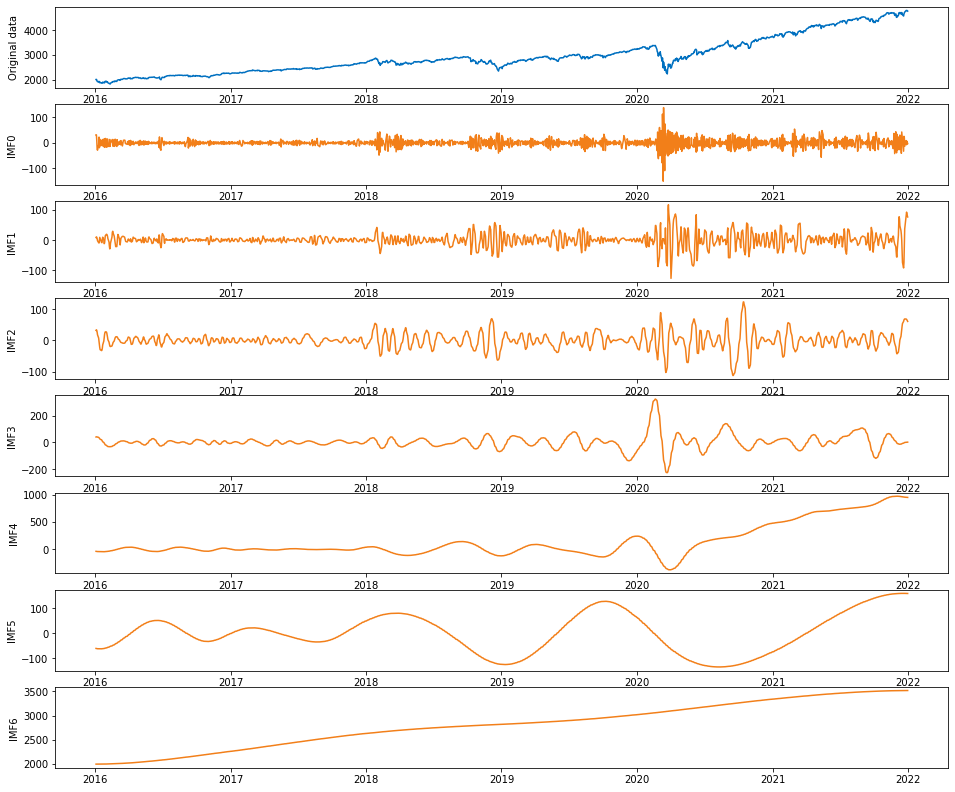

In [320]:
emdre=emd_calculate(GSPC_test)
reedm=reconstruction(emdre)

In [345]:
pure_mm_cnn=pd.DataFrame(reedm.iloc[1,:]).rename(columns={'sum1':'Adj Close'})
pure_mm_cnn

,Adj Close
Date,
2016-01-04,1981.038478
2016-01-05,1985.092161
2016-01-06,1980.223760
2016-01-07,1967.951069
2016-01-08,1950.617911
...,...
2021-12-27,4781.977785
2021-12-28,4793.422988
2021-12-29,4786.586356


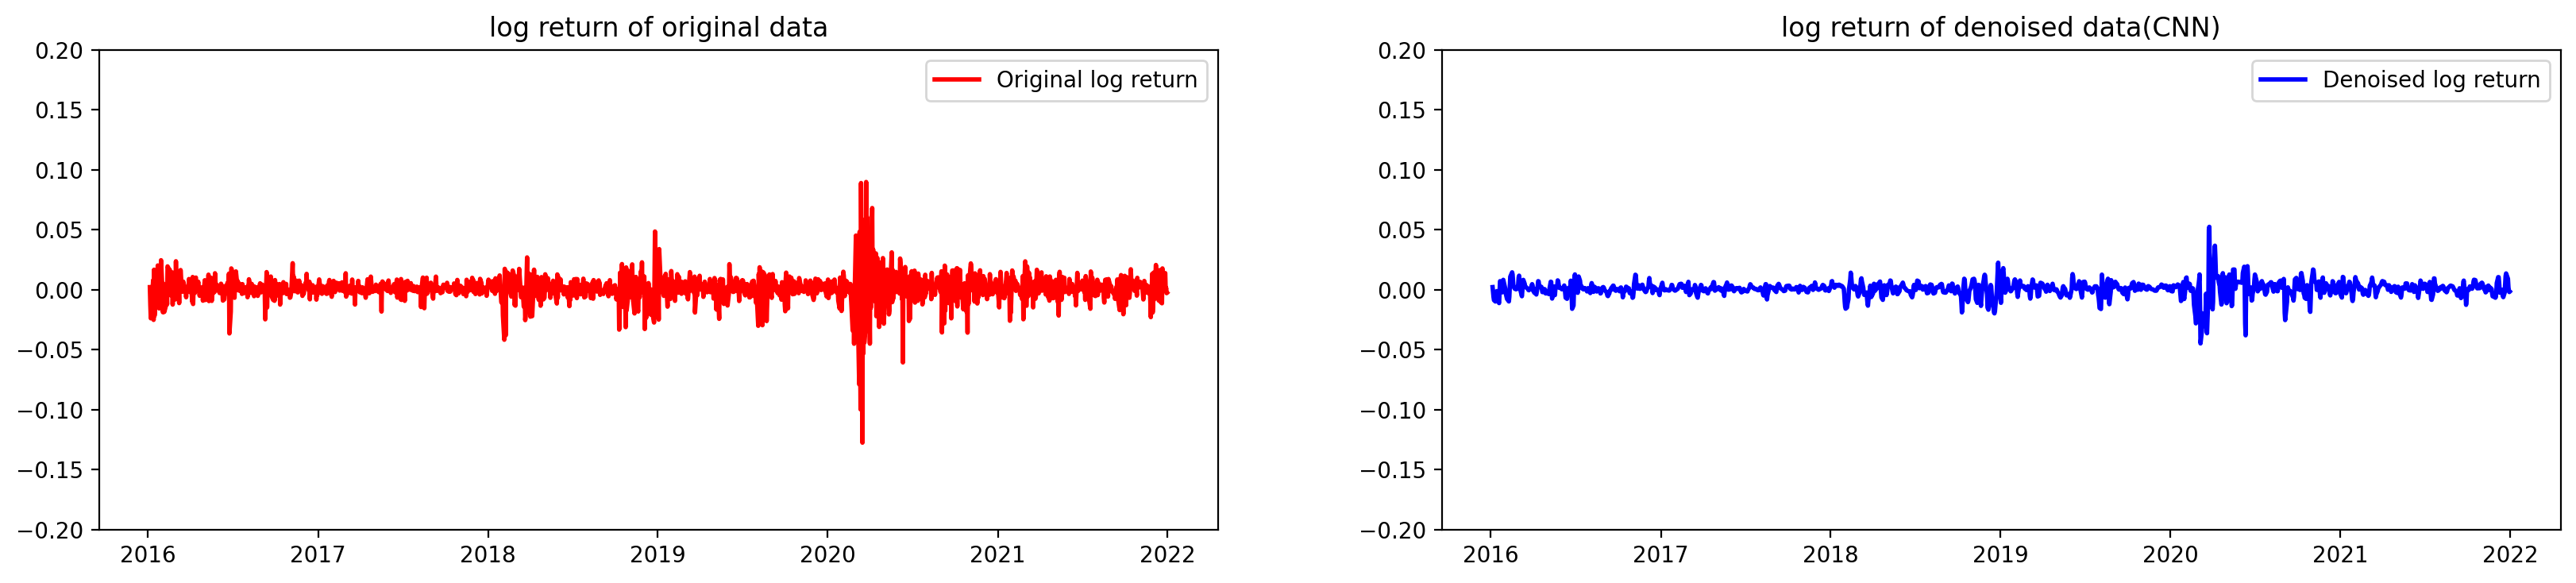

In [334]:
# Log Returns
GSPC_test_n=GSPC_test.copy()
GSPC_test_n['log_ret'] = np.log(GSPC_test.iloc[:,0]).diff()
pure_mm_cnn['log_ret'] = np.log(pure_mm_cnn.iloc[:,0]).diff()


plt.figure(figsize=(20,4),dpi=200)
plt.subplot(1,2,1)
plt.plot(GSPC_test_n['log_ret'], 'r-', linewidth=2, label='Original log return')
plt.ylim(-0.2,0.2)
plt.title('log return of original data')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(pure_mm_cnn['log_ret'] , 'b-', linewidth=2, label='Denoised log return')
plt.ylim(-0.2,0.2)
plt.title('log return of denoised data(CNN)')
plt.legend(loc='best')


plt.show()

In [335]:
def svmf1(dataset,dataset2,long_predict=10,percentage=1):
    f11=np.empty(0)
    f12=np.empty(0)
    max_t=0
    if dataset['log_ret'].max()>dataset2['log_ret'].max():
        max_t=dataset2['log_ret'].max()
    else:
        max_t=dataset['log_ret'].max()
    for n in np.arange(0.0, (percentage*max_t), (percentage*max_t)/50):#get multiple threshold
        threshold = n
        # for dataset
        daily_label=np.empty(0)#make the data labelled
        for i in range(0,len(dataset)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label=np.append(daily_label,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label=np.append(daily_label,n)
            else:
                n=1
                daily_label=np.append(daily_label,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f11=np.append(f11,f1)
        
        # for dataset2
    for n in np.arange(0.0, (0.5*max_t), (0.5*max_t)/50):#get multiple threshold
        threshold = n
        daily_label2=np.empty(0)#make the data labelled
        for i in range(0,len(dataset2)):
            if dataset2.iloc[i,1]<-threshold:
                n=-1
                daily_label2=np.append(daily_label2,n)
            elif abs(dataset2.iloc[i,1])<=threshold:
                n=0
                daily_label2=np.append(daily_label2,n)
            else:
                n=1
                daily_label2=np.append(daily_label2,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset2)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset2.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label2[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f12=np.append(f12,f1)
    return f11,f12

In [336]:
original_svm,denoised_svm=svmf1(GSPC_test_n,pure_mm_cnn,long_predict=1)

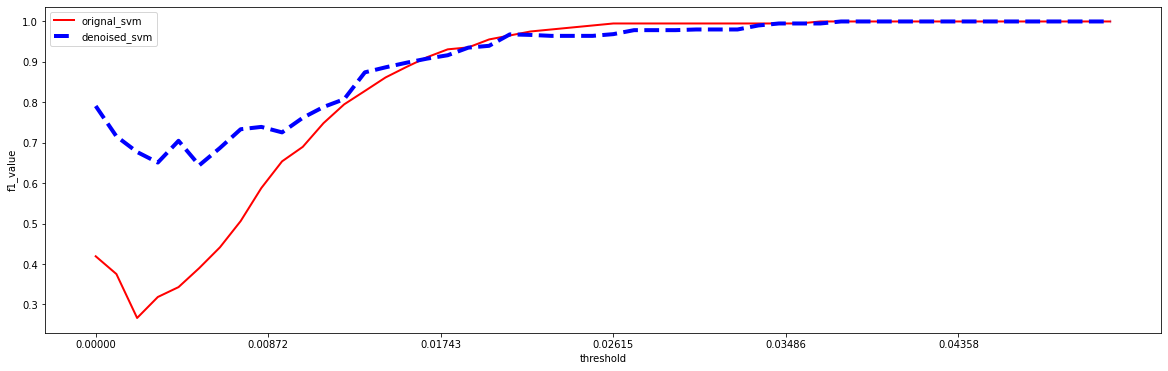

In [337]:
plt.figure(figsize=(20,6))
percentage=1
max_t=0
if GSPC_test_n['log_ret'].max()>pure_mm_cnn['log_ret'].max():
    max_t=pure_mm_cnn['log_ret'].max()
else:
    max_t=GSPC_test_n['log_ret'].max()
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/50),original_svm,label='orignal_svm', color='red', linewidth=2.0)
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/50),denoised_svm,label='denoised_svm', color='blue', linewidth=4.0, linestyle='--')

plt.xticks(np.arange(0.0,(percentage*max_t), (percentage*max_t)/6))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()

In [338]:
def svmf1_ori(dataset,dataset2,long_predict=10,percentage=1):
    f11=np.empty(0)
    f12=np.empty(0)
    max_t=0
    if dataset['log_ret'].max()>dataset2['log_ret'].max():
        max_t=dataset2['log_ret'].max()
    else:
        max_t=dataset['log_ret'].max()
    for n in np.arange(0.0, (percentage*max_t), (percentage*max_t)/50):#get multiple threshold
        threshold = n
        # for dataset
        daily_label=np.empty(0)#make the data labelled
        for i in range(0,len(dataset)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label=np.append(daily_label,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label=np.append(daily_label,n)
            else:
                n=1
                daily_label=np.append(daily_label,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f11=np.append(f11,f1)
        
        # for dataset2
    for n in np.arange(0.0, (0.5*max_t), (0.5*max_t)/50):#get multiple threshold
        threshold = n
        daily_label2=np.empty(0)#make the data labelled
        for i in range(0,len(dataset2)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label2=np.append(daily_label2,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label2=np.append(daily_label2,n)
            else:
                n=1
                daily_label2=np.append(daily_label2,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset2)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset2.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label2[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f12=np.append(f12,f1)
    return f11,f12

In [339]:
original_svm_ori,denoised_svm_ori=svmf1_ori(GSPC_test_n,pure_mm_cnn,long_predict=1)

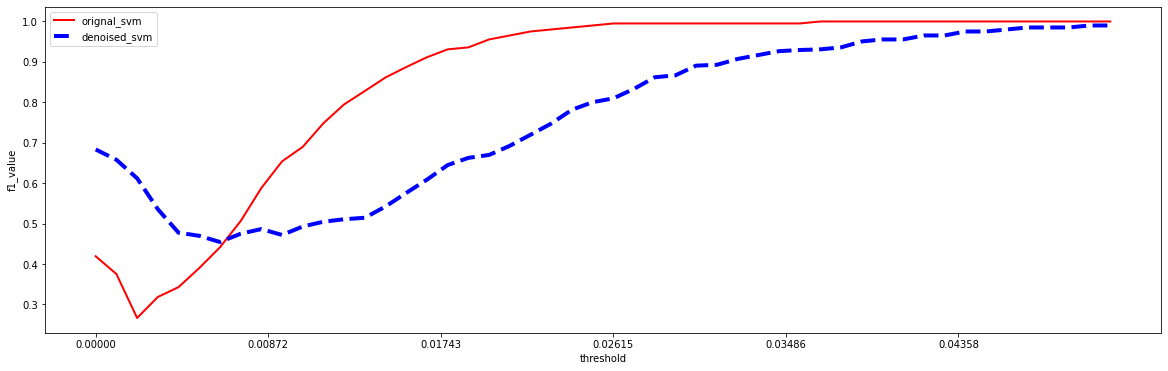

In [340]:
plt.figure(figsize=(20,6))
percentage=1
max_t=0
if GSPC_test_n['log_ret'].max()>pure_mm_cnn['log_ret'].max():
    max_t=pure_mm_cnn['log_ret'].max()
else:
    max_t=GSPC_test_n['log_ret'].max()
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/50),original_svm_ori,label='orignal_svm', color='red', linewidth=2.0)
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/50),denoised_svm_ori,label='denoised_svm', color='blue', linewidth=4.0, linestyle='--')

plt.xticks(np.arange(0.0,(percentage*max_t), (percentage*max_t)/6))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()

## Strategies 

## Bollinger band

In [346]:
def bbands(close_prices, window, no_of_stdev):#bollinger  bands, using today's closing price

    rolling_mean = close_prices.rolling(window,min_periods=1).mean()#.shift(1)
    rolling_std = close_prices.rolling(window,min_periods=1).std()#.shift(1)
    

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band

In [347]:
def buy_signal_function(dataset):
    buy_signal=pd.DataFrame(columns=['Price'],index=dataset.index)
    buy_signal['Price']=dataset['Adj Close']
    buy_signal['mean'],buy_signal['upper'],buy_signal['lower']=bbands(dataset['Adj Close'],20,2)
    buy_signal['side'] = np.nan 
    buy_signal['signal'] = np.nan 
    for i in range(0,len(dataset)):
        if (buy_signal.iloc[i,0]<buy_signal.iloc[i,3]):
            buy_signal.iloc[i,4]=1
            if (buy_signal.iloc[i-1,0]>=buy_signal.iloc[i-1,3]):
                buy_signal.iloc[i,5]=1
        elif (buy_signal.iloc[i,0]>buy_signal.iloc[i,2]):
            buy_signal.iloc[i,4]=-1
            if (buy_signal.iloc[i-1,0]<=buy_signal.iloc[i-1,2]):
                buy_signal.iloc[i,5]=-1
    return buy_signal

In [348]:
GSPC_test_signal=buy_signal_function(GSPC_test_n)


pure_mm_cnn_signal=buy_signal_function(pure_mm_cnn)


In [349]:

print('GSPC_test_signal:\n',GSPC_test_signal.signal.value_counts(),'\n')
print('pure_mm_cnn_signal:\n',pure_mm_cnn_signal.signal.value_counts(),'\n')


GSPC_test_signal:
 -1.0    47
 1.0    34
Name: signal, dtype: int64 

pure_mm_cnn_signal:
 -1.0    38
 1.0    24
Name: signal, dtype: int64 



In [350]:
print(GSPC_test[GSPC_test_signal.signal == 1.0])
print(GSPC_test[pure_mm_cnn_signal.signal == 1.0])

              Adj Close
Date                   
2016-06-24  2037.410034
2016-09-09  2127.810059
2016-09-13  2127.020020
2016-11-01  2111.719971
2017-03-21  2344.020020
2017-04-13  2328.949951
2017-06-29  2419.699951
2017-07-06  2409.750000
2017-08-10  2438.209961
2017-08-17  2430.010010
2018-02-05  2648.939941
2018-02-08  2581.000000
2018-03-22  2643.689941
2018-06-27  2699.629883
2018-10-10  2785.679932
2018-10-24  2656.100098
2018-12-17  2545.939941
2018-12-19  2506.959961
2019-05-13  2811.870117
2019-05-31  2752.060059
2019-08-01  2953.560059
2019-10-01  2940.250000
2020-02-25  3128.209961
2020-03-09  2746.560059
2020-03-12  2480.639893
2020-03-16  2386.129883
2020-10-28  3271.030029
2020-10-30  3269.959961
2021-03-04  3768.469971
2021-05-12  4063.040039
2021-09-20  4357.729980
2021-09-30  4307.540039
2021-11-26  4594.620117
2021-11-30  4567.000000
              Adj Close
Date                   
2016-02-09  1852.209961
2016-06-24  2037.410034
2016-09-08  2181.300049
2016-10-12  2139

In [351]:
print(GSPC_test[GSPC_test_signal.signal == -1.0])
print(GSPC_test[pure_mm_cnn_signal.signal == -1.0])

              Adj Close
Date                   
2016-04-13  2082.419922
2016-04-18  2094.340088
2016-05-25  2090.540039
2016-05-27  2099.060059
2016-12-07  2241.350098
2016-12-13  2271.719971
2017-01-25  2298.370117
2017-02-10  2316.100098
2017-02-21  2365.379883
2017-04-25  2388.610107
2017-06-02  2439.070068
2017-07-14  2459.270020
2017-07-19  2473.830078
2017-09-12  2496.479980
2017-10-05  2552.070068
2017-10-27  2581.070068
2017-11-28  2627.040039
2018-01-04  2723.989990
2018-01-12  2786.239990
2018-05-10  2723.070068
2018-06-06  2772.350098
2018-08-27  2896.739990
2018-09-20  2930.750000
2019-03-18  2832.939941
2019-03-21  2854.879883
2019-07-03  2995.820068
2019-09-05  2976.000000
2019-12-12  3168.570068
2019-12-16  3191.449951
2019-12-20  3221.219971
2020-01-16  3316.810059
2020-05-27  3036.129883
2020-06-05  3193.929932
2020-08-06  3349.159912
2020-08-26  3478.729980
2020-08-28  3508.010010
2020-09-02  3580.840088
2020-10-12  3534.219971
2020-12-31  3756.070068
2021-01-07  3803

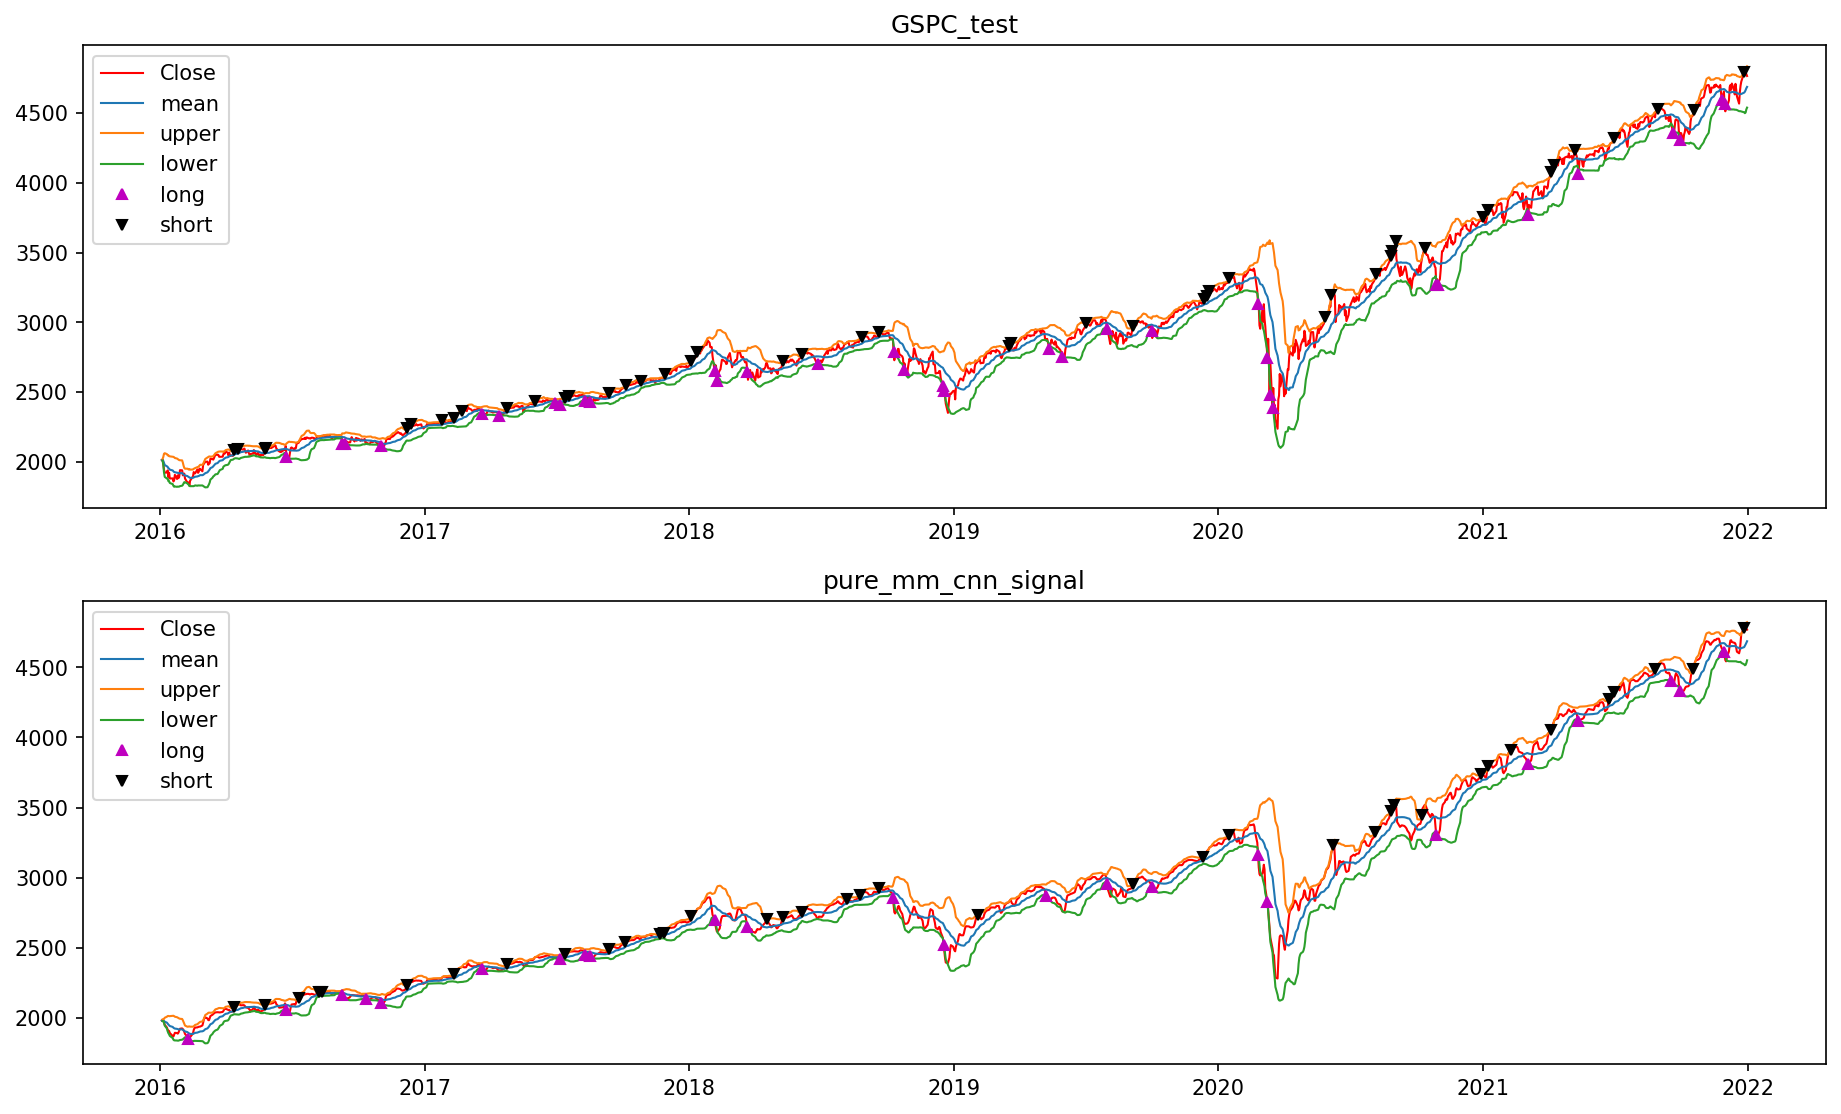

In [352]:
plt.figure(figsize=(15,9),dpi=150)
plt.subplot(2,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test_signal['Price'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_signal[['mean','upper','lower']], lw=1,label=['mean','upper','lower'])
plt.plot(GSPC_test_signal.loc[GSPC_test_signal.signal == 1.0].index, 
         GSPC_test_signal.Price[GSPC_test_signal.signal == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_signal.loc[GSPC_test_signal.signal == -1.0].index, 
         GSPC_test_signal.Price[GSPC_test_signal.signal == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(2,1,2)
plt.title('pure_mm_cnn_signal')
plt.plot(pure_mm_cnn_signal['Price'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_signal[['mean','upper','lower']], lw=1,label=['mean','upper','lower'])
plt.plot(pure_mm_cnn_signal.loc[pure_mm_cnn_signal.signal == 1.0].index, 
         pure_mm_cnn_signal.Price[pure_mm_cnn_signal.signal == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnn_signal.loc[pure_mm_cnn_signal.signal == -1.0].index, 
         pure_mm_cnn_signal.Price[pure_mm_cnn_signal.signal == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()    


## MACD

In [353]:
def MACD(dataset,short_window = 12,long_window = 26, signal_window=9):
    # Initiate short and long windows

    # Initialise the `signals` dataframe and add the `signal` column
    signals = pd.DataFrame(index=dataset.index)
    signals['signal'] = 0.0

    # Calculate short term moving averages
    signals['short_mavg'] = dataset['Adj Close'].ewm(span=short_window, min_periods=1).mean()

    # Calculate long term moving averages
    signals['long_mavg'] = dataset['Adj Close'].ewm(span=long_window, min_periods=1).mean()
    
    # Calculate DIF 
    signals['DIF'] = signals['short_mavg']-signals['long_mavg']
    
     # Calculate DIF moving averages
    signals['DEA'] = signals['DIF'].ewm(span=signal_window, min_periods=1).mean()

    # Generate signal
    signals['signal'] = np.where(signals['DIF']> signals['DEA'], 1.0, 0.0)   

    # Generate trading orders
    signals['positions'] = signals['signal'].diff()
    return signals

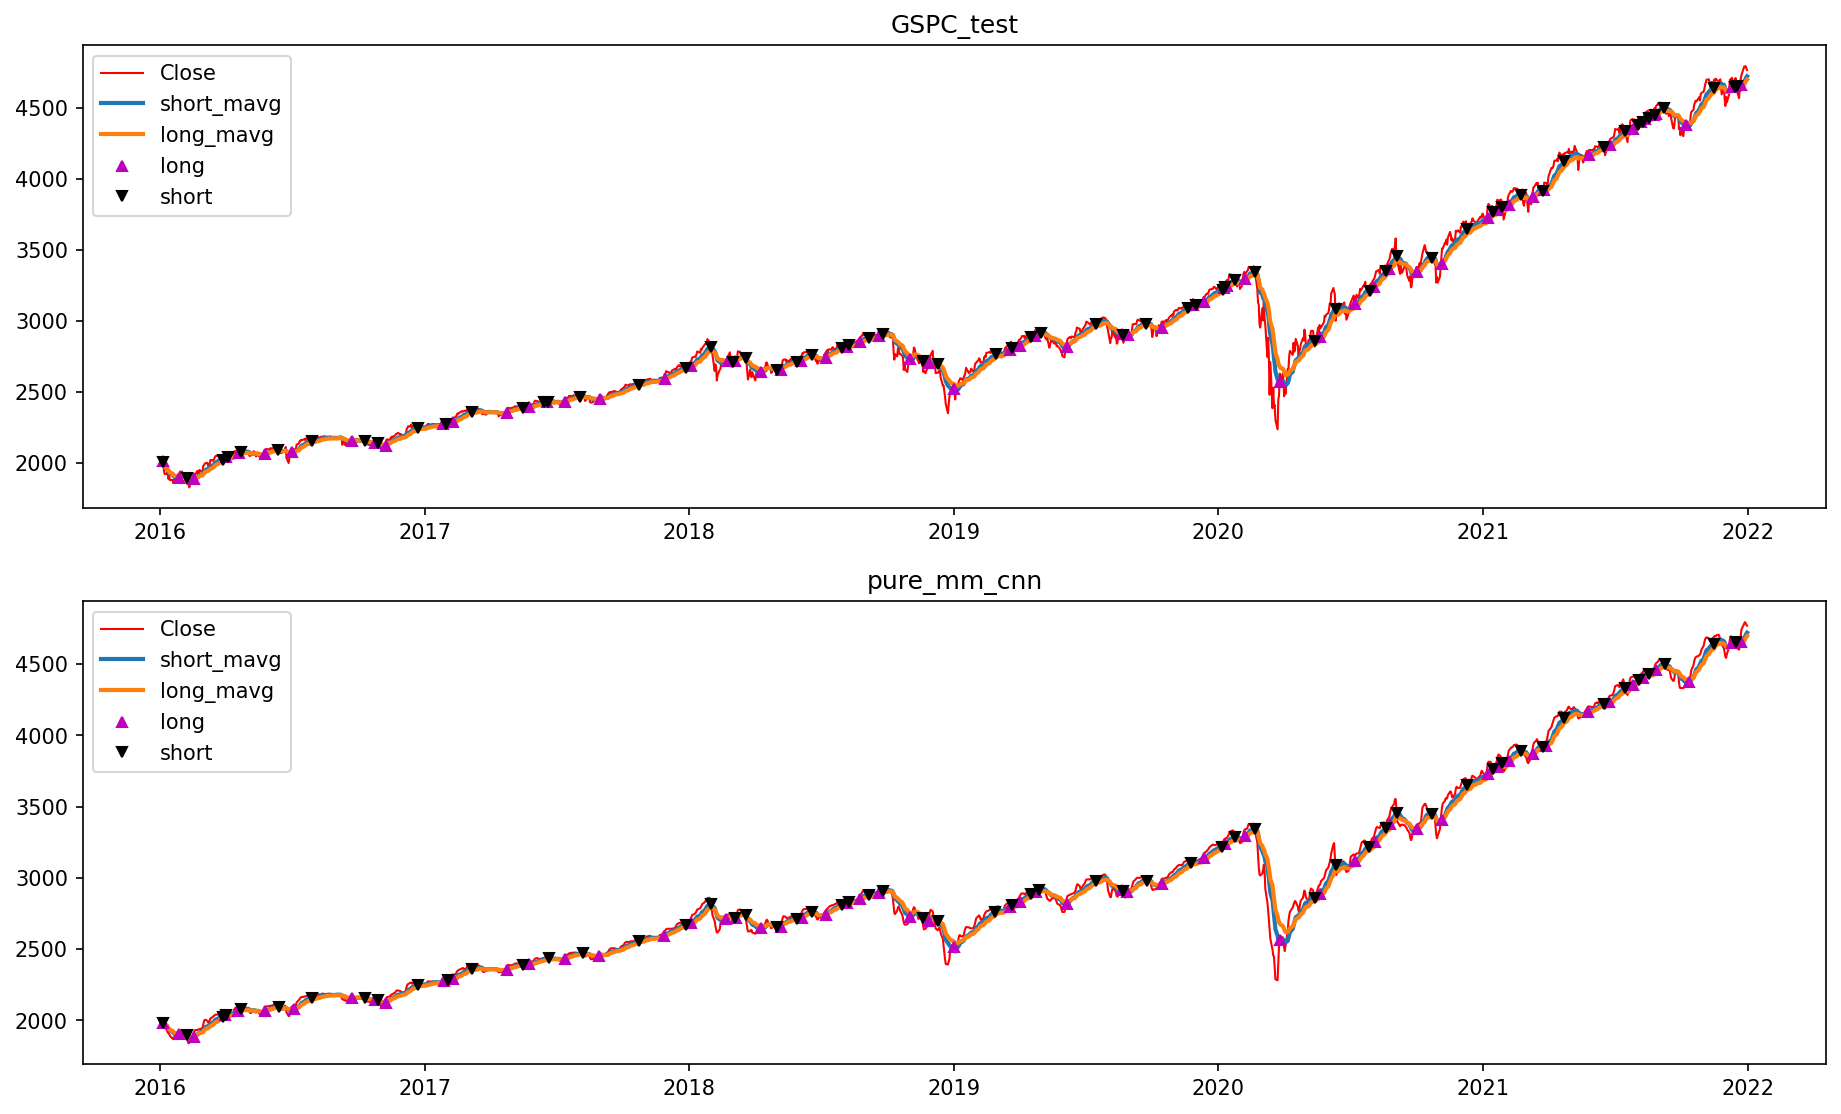

In [354]:
GSPC_test_macd=MACD(GSPC_test_n,short_window = 14,long_window = 22)
pure_mm_cnn_macd=MACD(pure_mm_cnn,short_window = 14,long_window = 22)
#pure_mm_lstm_macd=MACD(pure_mm_lstm,short_window = 14,long_window = 22)

plt.figure(figsize=(15,9),dpi=150)
plt.subplot(2,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test_n['Adj Close'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_macd[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(GSPC_test_macd.loc[GSPC_test_macd.positions == 1.0].index, 
         GSPC_test_macd.short_mavg[GSPC_test_macd.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_macd.loc[GSPC_test_macd.positions == -1.0].index, 
         GSPC_test_macd.short_mavg[GSPC_test_macd.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(2,1,2)
plt.title('pure_mm_cnn')
plt.plot(pure_mm_cnn['Adj Close'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_macd[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(pure_mm_cnn_macd.loc[pure_mm_cnn_macd.positions == 1.0].index, 
         pure_mm_cnn_macd.short_mavg[pure_mm_cnn_macd.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnn_macd.loc[pure_mm_cnn_macd.positions == -1.0].index, 
         pure_mm_cnn_macd.short_mavg[pure_mm_cnn_macd.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()   



In [355]:
print('GSPC_test_macd:\n',GSPC_test_macd.positions.value_counts(),'\n')
print('pure_mm_cnn_macd:\n',pure_mm_cnn_macd.positions.value_counts(),'\n')

GSPC_test_macd:
  0.0    1379
 1.0      66
-1.0      65
Name: positions, dtype: int64 

pure_mm_cnn_macd:
  0.0    1391
 1.0      60
-1.0      59
Name: positions, dtype: int64 



In [356]:
print(GSPC_test[GSPC_test_macd['positions']==1])
print(GSPC_test[pure_mm_cnn_macd['positions']==1])

              Adj Close
Date                   
2016-01-05  2016.709961
2016-01-27  1882.949951
2016-02-17  1926.819946
2016-04-01  2072.780029
2016-04-19  2100.800049
...                 ...
2021-08-27  4509.370117
2021-10-08  4391.339844
2021-12-10  4712.020020
2021-12-15  4709.850098
2021-12-23  4725.790039

[66 rows x 1 columns]
              Adj Close
Date                   
2016-01-05  2016.709961
2016-01-28  1893.359985
2016-02-17  1926.819946
2016-03-31  2059.739990
2016-04-18  2094.340088
2016-05-25  2090.540039
2016-07-05  2088.550049
2016-09-23  2164.689941
2016-10-24  2151.330078
2016-11-08  2139.560059
2017-01-27  2294.689941
2017-02-09  2307.870117
2017-04-24  2374.149902
2017-05-25  2415.070068
2017-07-13  2447.830078
2017-08-29  2446.300049
2017-11-27  2601.419922
2018-01-04  2723.989990
2018-02-21  2701.330078
2018-03-07  2726.800049
2018-04-10  2656.870117
2018-05-07  2672.629883
2018-06-05  2748.800049
2018-07-09  2784.169922
2018-08-06  2850.399902
2018-08-24  2874.

In [357]:
print(GSPC_test[GSPC_test_macd['positions']==-1])
print(GSPC_test[pure_mm_cnn_macd['positions']==-1])

              Adj Close
Date                   
2016-01-06  1990.260010
2016-02-08  1853.439941
2016-03-28  2037.050049
2016-04-04  2066.129883
2016-04-22  2091.580078
...                 ...
2021-08-26  4470.000000
2021-09-08  4514.069824
2021-11-15  4682.799805
2021-12-14  4634.089844
2021-12-17  4620.640137

[65 rows x 1 columns]
              Adj Close
Date                   
2016-01-06  1990.260010
2016-02-08  1853.439941
2016-03-28  2037.050049
2016-04-01  2072.780029
2016-04-22  2091.580078
2016-06-14  2075.320068
2016-07-29  2173.600098
2016-10-11  2136.729980
2016-10-28  2126.409912
2016-12-22  2260.959961
2017-02-02  2280.850098
2017-03-07  2368.389893
2017-05-16  2400.669922
2017-06-21  2435.610107
2017-08-07  2480.909912
2017-10-24  2569.129883
2017-12-28  2687.540039
2018-01-31  2823.810059
2018-03-05  2720.939941
2018-03-20  2716.939941
2018-05-02  2635.669922
2018-05-29  2689.860107
2018-06-19  2762.590088
2018-07-31  2816.290039
2018-08-10  2833.280029
2018-09-06  2878.

## MA

In [358]:
def MA(dataset,short_window = 10,long_window = 50):
    # Initiate short and long windows

    # Initialise the `signals` dataframe and add the `signal` column
    signals = pd.DataFrame(index=dataset.index)
    signals['signal'] = 0.0

    # Calculate short term simple moving averages
    signals['short_mavg'] = dataset['Adj Close'].rolling(window=short_window, min_periods=1).mean()

    # Calculate long term simple moving averages
    signals['long_mavg'] = dataset['Adj Close'].rolling(window=long_window, min_periods=1).mean()

    # Generate signal
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                                > signals['long_mavg'][short_window:], 1.0, 0.0)   

    # Generate trading orders
    signals['positions'] = signals['signal'].diff()
    return signals

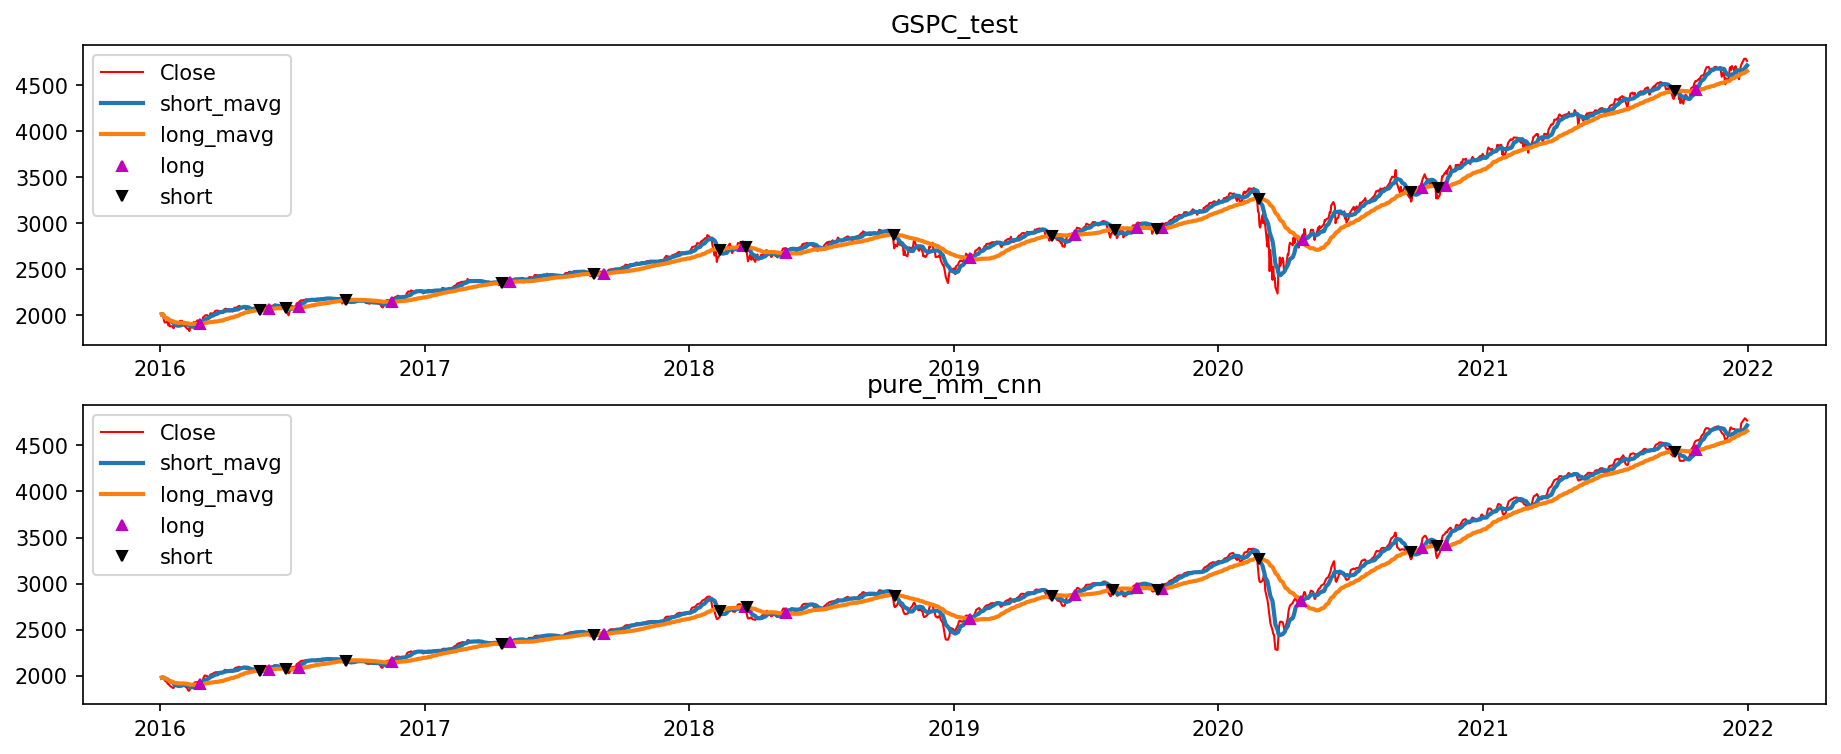

In [359]:
GSPC_test_ma=MA(GSPC_test,short_window = 10,long_window = 50)
pure_mm_cnn_ma=MA(pure_mm_cnn,short_window = 10,long_window = 50)
#pure_mm_lstm_ma=MA(pure_mm_lstm,short_window = 10,long_window = 50)

plt.figure(figsize=(15,9),dpi=150)
plt.subplot(3,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test['Adj Close'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_ma[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(GSPC_test_ma.loc[GSPC_test_ma.positions == 1.0].index, 
         GSPC_test_ma.short_mavg[GSPC_test_ma.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_ma.loc[GSPC_test_ma.positions == -1.0].index, 
         GSPC_test_ma.short_mavg[GSPC_test_ma.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(3,1,2)
plt.title('pure_mm_cnn')
plt.plot(pure_mm_cnn['Adj Close'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_ma[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(pure_mm_cnn_ma.loc[pure_mm_cnn_ma.positions == 1.0].index, 
         pure_mm_cnn_ma.short_mavg[pure_mm_cnn_ma.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnn_ma.loc[pure_mm_cnn_ma.positions == -1.0].index, 
         pure_mm_cnn_ma.short_mavg[pure_mm_cnn_ma.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()   



In [360]:
print('GSPC_test_ma:\n',GSPC_test_ma.positions.value_counts(),'\n')
print('pure_mm_cnn_ma:\n',pure_mm_cnn_ma.positions.value_counts(),'\n')

GSPC_test_ma:
  0.0    1479
 1.0      16
-1.0      15
Name: positions, dtype: int64 

pure_mm_cnn_ma:
  0.0    1479
 1.0      16
-1.0      15
Name: positions, dtype: int64 



In [361]:
print(GSPC_test[GSPC_test_ma['positions']==1])
print(GSPC_test[pure_mm_cnn_ma['positions']==1])

              Adj Close
Date                   
2016-02-25  1951.699951
2016-05-31  2096.949951
2016-07-11  2137.159912
2016-11-16  2176.939941
2017-04-28  2384.199951
2017-09-05  2457.850098
2018-03-16  2752.010010
2018-05-14  2730.129883
2019-01-24  2642.330078
2019-06-18  2917.750000
2019-09-11  3000.929932
2019-10-16  2989.689941
2020-04-27  2878.479980
2020-10-09  3477.139893
2020-11-10  3545.530029
2021-10-21  4549.779785
              Adj Close
Date                   
2016-02-25  1951.699951
2016-05-31  2096.949951
2016-07-11  2137.159912
2016-11-16  2176.939941
2017-04-28  2384.199951
2017-09-05  2457.850098
2018-03-19  2712.919922
2018-05-14  2730.129883
2019-01-23  2638.699951
2019-06-18  2917.750000
2019-09-11  3000.929932
2019-10-16  2989.689941
2020-04-24  2836.739990
2020-10-09  3477.139893
2020-11-10  3545.530029
2021-10-21  4549.779785


In [362]:
print(GSPC_test[GSPC_test_ma['positions']==-1])
print(GSPC_test[pure_mm_cnn_ma['positions']==-1])

              Adj Close
Date                   
2016-05-19  2040.040039
2016-06-24  2037.410034
2016-09-14  2125.770020
2017-04-17  2349.010010
2017-08-22  2452.510010
2018-02-12  2656.000000
2018-03-20  2716.939941
2018-10-11  2728.370117
2019-05-17  2859.530029
2019-08-12  2882.699951
2019-10-09  2919.399902
2020-02-27  2978.760010
2020-09-23  3236.919922
2020-10-30  3269.959961
2021-09-22  4395.640137
              Adj Close
Date                   
2016-05-19  2040.040039
2016-06-24  2037.410034
2016-09-14  2125.770020
2017-04-17  2349.010010
2017-08-22  2452.510010
2018-02-12  2656.000000
2018-03-21  2711.929932
2018-10-12  2767.129883
2019-05-17  2859.530029
2019-08-09  2918.649902
2019-10-10  2938.129883
2020-02-27  2978.760010
2020-09-23  3236.919922
2020-10-29  3310.110107
2021-09-23  4448.979980


## Strategies backtest

In [363]:
def combinesig(dataset,dataset1,dataset2,dataset3):    
    dataset_backtesting=pd.DataFrame()
    dataset_backtesting['Adj Close']=dataset['Adj Close']
    dataset_backtesting['masig']=dataset1['positions']
    dataset_backtesting['macdsig']=dataset2['positions']
    dataset_backtesting['bbsig']=dataset3['signal']
    return dataset_backtesting

In [364]:
GSPC_backtesting=combinesig(GSPC_test,GSPC_test_ma,GSPC_test_macd,GSPC_test_signal)
pure_mm_cnn_backtesting=combinesig(GSPC_test,pure_mm_cnn_ma,pure_mm_cnn_macd,pure_mm_cnn_signal)


In [365]:
def backtest(dataset,asset=1e8, signal=''):
    share_number = 0
    cash = asset
    for i in range(len(dataset)):
        if dataset[signal][i]==1:
            share_number=share_number+cash//(100*dataset['Adj Close'][i])*100
            if cash//(100*dataset['Adj Close'][i])*100>0:
                cash=cash-cash//(100*dataset['Adj Close'][i])*100*dataset['Adj Close'][i]
        elif dataset[signal][i]==-1:
            cash=cash+share_number*dataset['Adj Close'][i]
            share_number=0
    asset_now=cash+share_number*dataset['Adj Close'][i]
    return_value=(asset_now-asset)/asset
    return return_value

In [366]:
mareturn=backtest(GSPC_backtesting,signal='masig')
mareturn_cnn=backtest(pure_mm_cnn_backtesting,signal='masig')
print(mareturn)
print(mareturn_cnn)


0.7008293969726562
0.8525811279296875


In [367]:
mareturn=backtest(GSPC_backtesting,signal='macdsig')
mareturn_cnn=backtest(pure_mm_cnn_backtesting,signal='macdsig')
#mareturn_lstm=backtest(pure_mm_lstm_backtesting,signal='macdsig')
print(mareturn)
print(mareturn_cnn)
#print(mareturn_lstm)

0.6365485061035157
1.0507844357910157


In [368]:
mareturn=backtest(GSPC_backtesting,signal='bbsig')
mareturn_cnn=backtest(pure_mm_cnn_backtesting,signal='bbsig')
print(mareturn)
print(mareturn_cnn)


1.0990810927734376
0.9002562735595703
